<h1>Data Exploration</h1>

<h3>Imports</h3>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import periodogram
from IPython.display import display

energy_df = pd.read_csv("energy_mv.csv")
weather_df = pd.read_csv("weather_df_1.csv")
df = pd.concat([energy_df, weather_df], axis=1)

df.to_csv("total_df_mv.csv", index=False)

df

time  total load actual  generation solar  \
0      2015-01-01 00:00:00+01:00            25385.0              49.0   
1      2015-01-01 01:00:00+01:00            24382.0              50.0   
2      2015-01-01 02:00:00+01:00            22734.0              50.0   
3      2015-01-01 03:00:00+01:00            21286.0              50.0   
4      2015-01-01 04:00:00+01:00            20264.0              42.0   
...                          ...                ...               ...   
35059  2018-12-31 19:00:00+01:00            30653.0              85.0   
35060  2018-12-31 20:00:00+01:00            29735.0              33.0   
35061  2018-12-31 21:00:00+01:00            28071.0              31.0   
35062  2018-12-31 22:00:00+01:00            25801.0              31.0   
35063  2018-12-31 23:00:00+01:00            24455.0              31.0   

       generation wind onshore  avg_temp  avg_humidity  avg_wind_speed  \
0                       6378.0     273.1          81.5             2.7   
1                       5890.0     273.1          81.5             2.7   
2                       5461.0     272.5          81.6             2.8   
3                       5238.0     272.5          81.6             2.8   
4                       4935.0     272.5          81.6             2.8   
...                        ...       ...           ...             ...   
35059                   3113.0     284.3          74.8             1.3   
35060                   3288.0     282.0          63.9             1.8   
35061                   3503.0     280.6          67.4             2.6   
35062                   3586.0     279.4          66.9             3.0   
35063                   3651.0     278.4          83.5             2.7   

       avg_rain_1h  avg_clouds_all  
0              0.0             0.0  
1              0.0             0.0  
2              0.0             0.0  
3              0.0             0.0  
4              0.0             0.0  
...            ...             ...  
35059          0.0             0.0  
35060          0.0             0.0  
35061          0.0             0.0  
35062          0.0             0.0  
35063          0.0             0.0  

[35064 rows x 9 columns]

<h3>Datetime formatting and month-average grouping</h3>

In [3]:
#REF: https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
# utc=True is necessary because of the different timezones present, so they are all unified by this. 

# Converting 'time' column to datetime and setting as index:
try:
    df["pd_datetime"] = pd.to_datetime(df["time"], utc=True, errors='raise')
    df.set_index("pd_datetime", inplace=True)
except Exception as e:
    print(f"Error while converting to datetime: {e}")

# Extracting month, year, and combined year_month from the index:
df["month"] = df.index.month
df["year"] = df.index.year
df["year_month"] = df["year"].astype(str) + '-' + df["month"].astype(str)

# Checking to ensure dataframe is datetime indexed:
if isinstance(df.index, pd.DatetimeIndex):
    print("\nThe dataframe is datetime indexed!\n")
else:
    print("\nThe dataframe does not have a datetime index - consider fixing.\n")



# The 'year' column here needs to come first so that it is the outer grouping:
df_month_grouped = df.groupby(["year", "month"]).mean().reset_index()
# Creating a new grouped column, all with two characters:
df_month_grouped["year_month"] = df_month_grouped["year"].astype(str) + '-' + df_month_grouped["month"].astype(str).str.zfill(2)




The dataframe is datetime indexed!



<h3>Monthly average line graphs and box plots</h3>

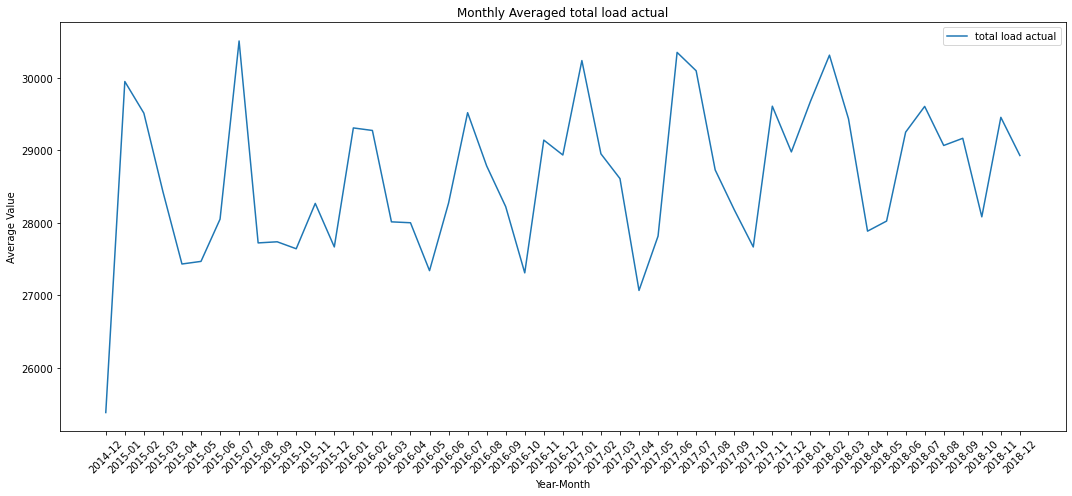

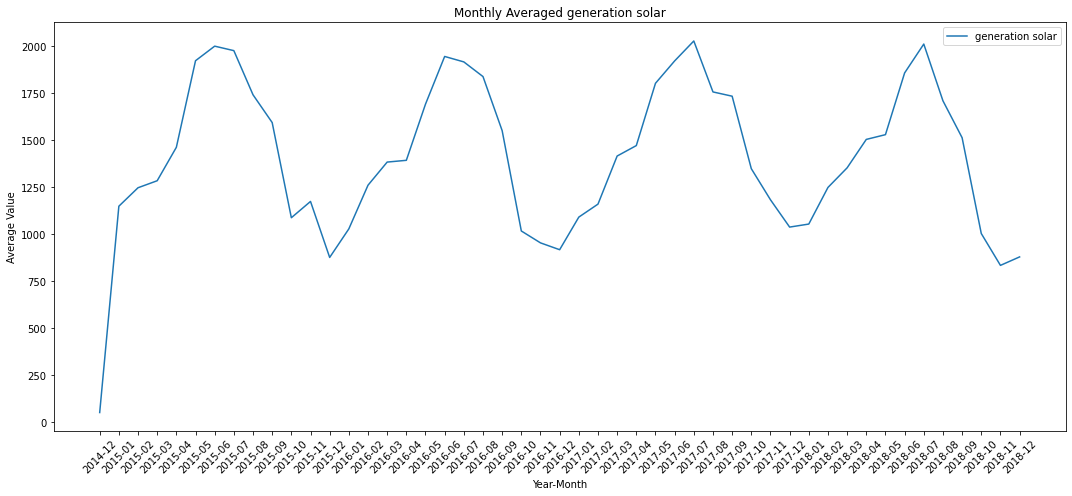

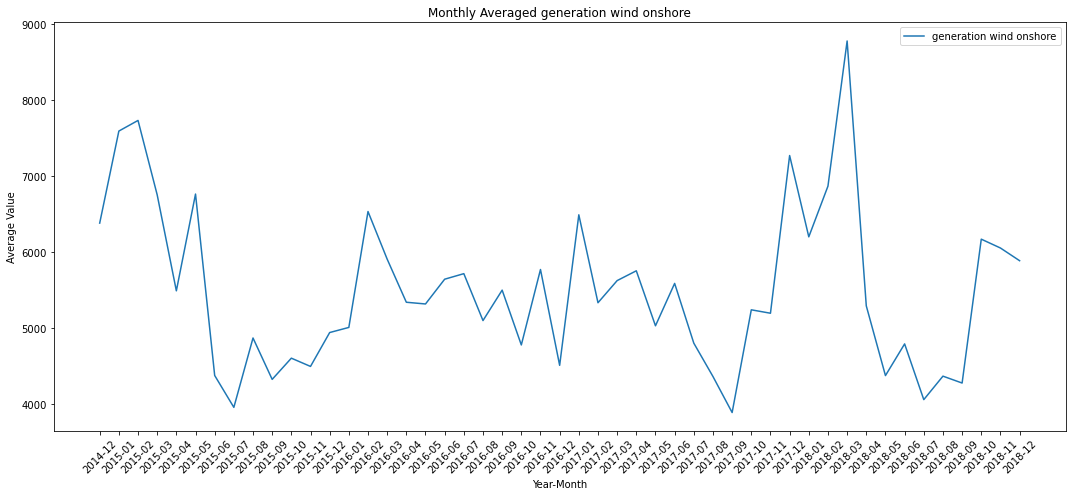

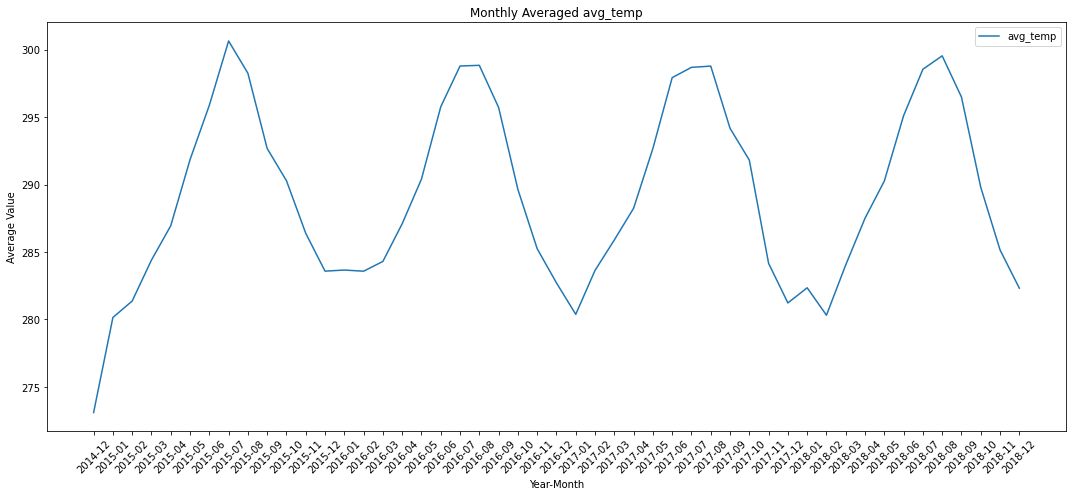

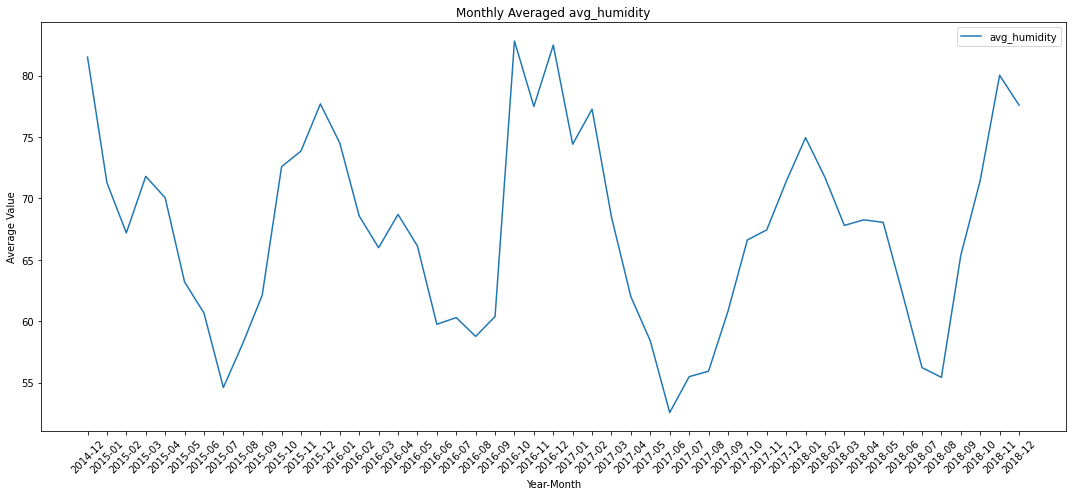

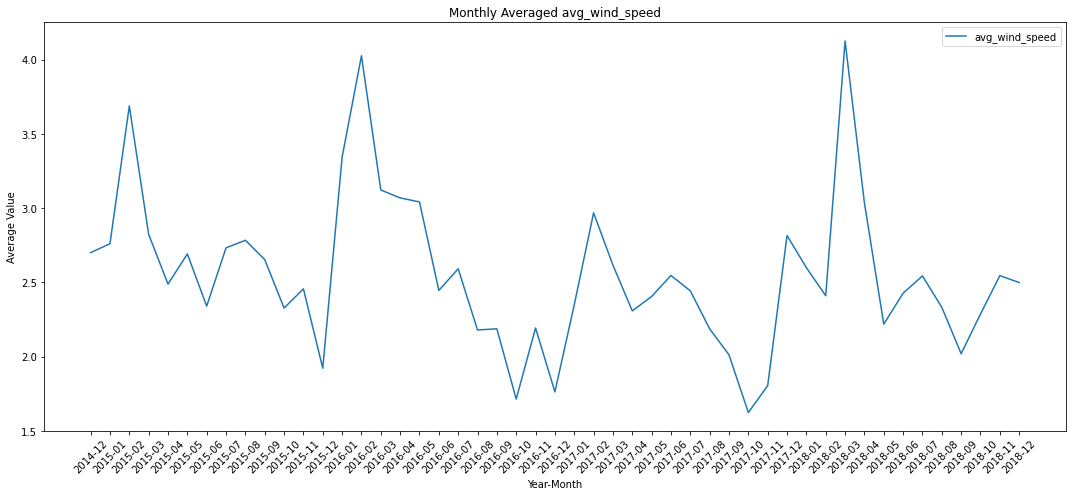

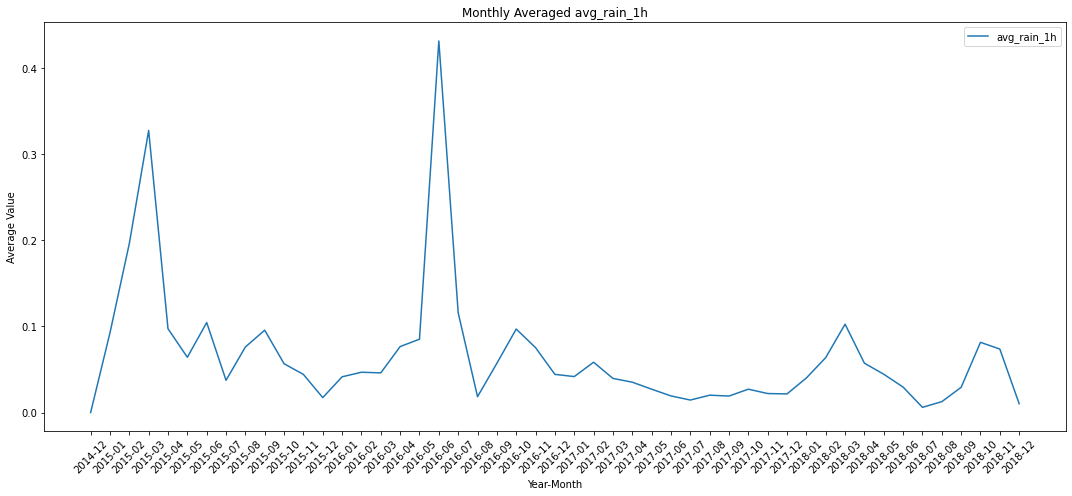

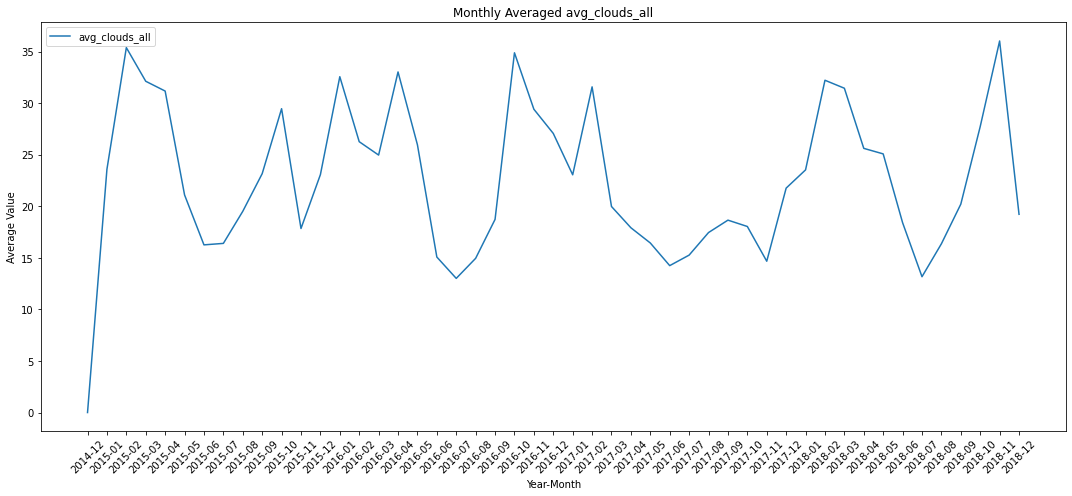

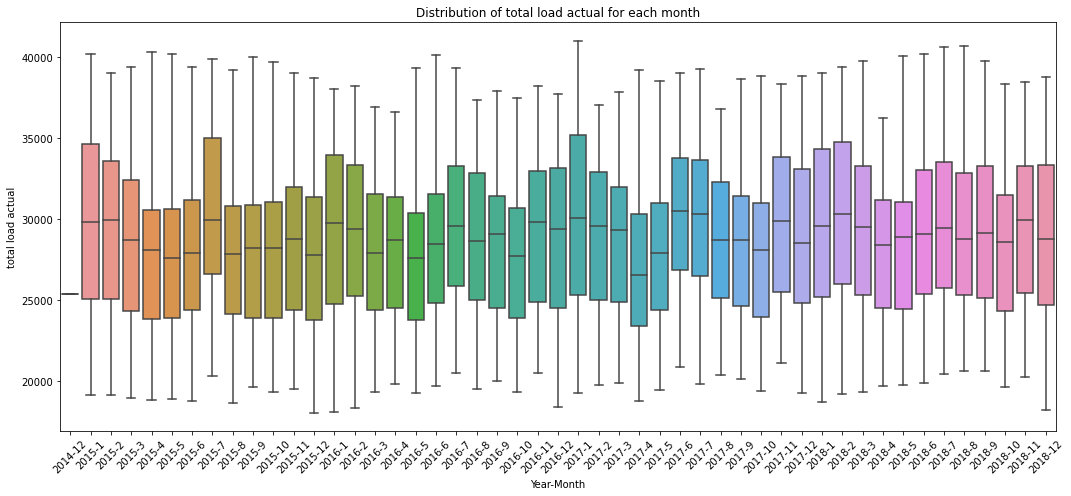

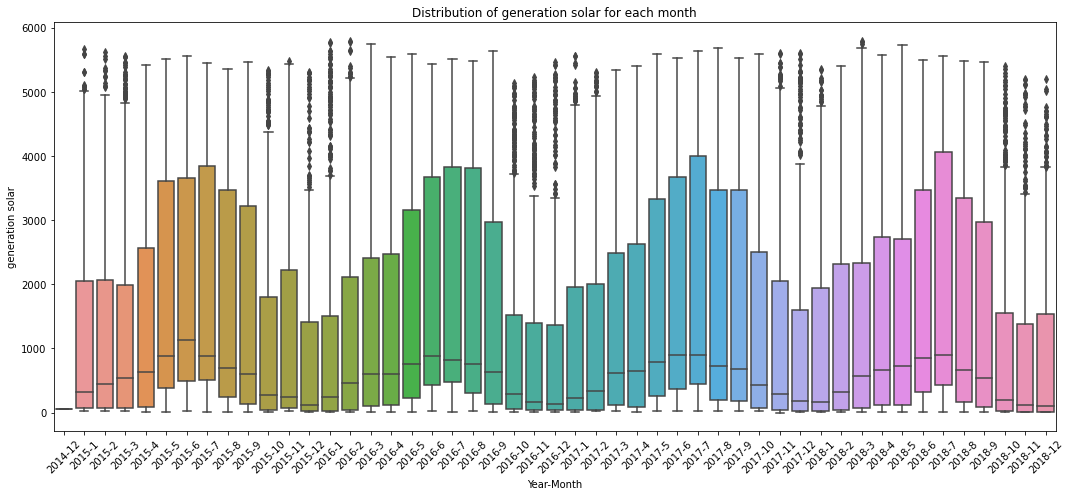

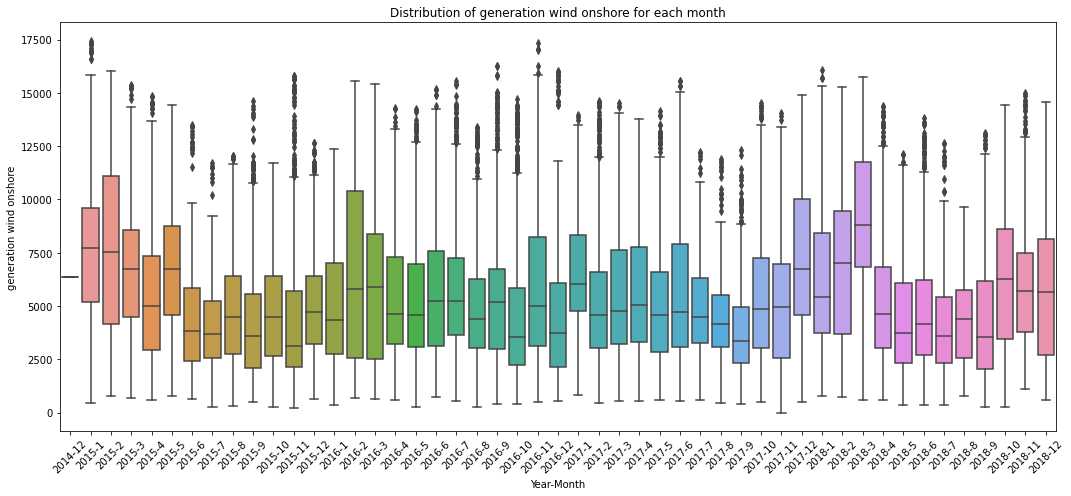

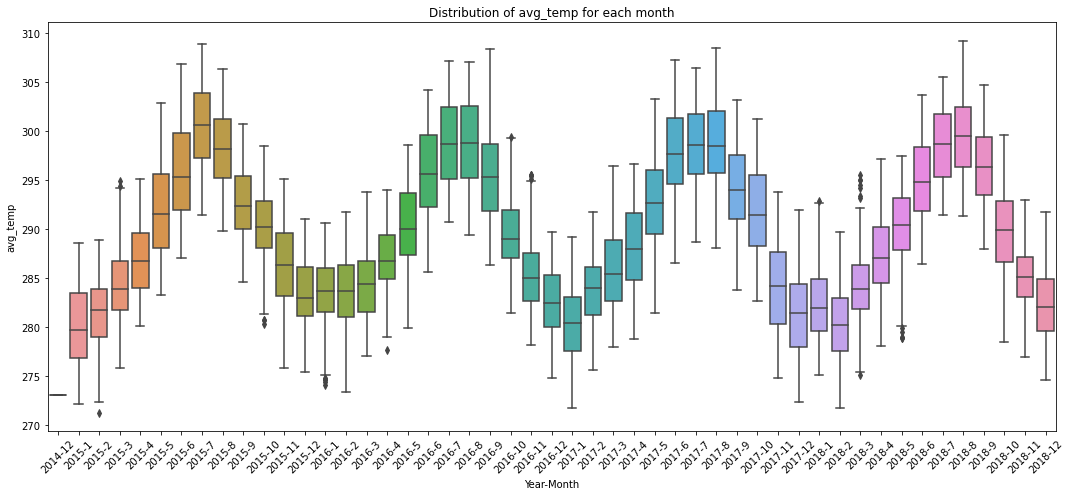

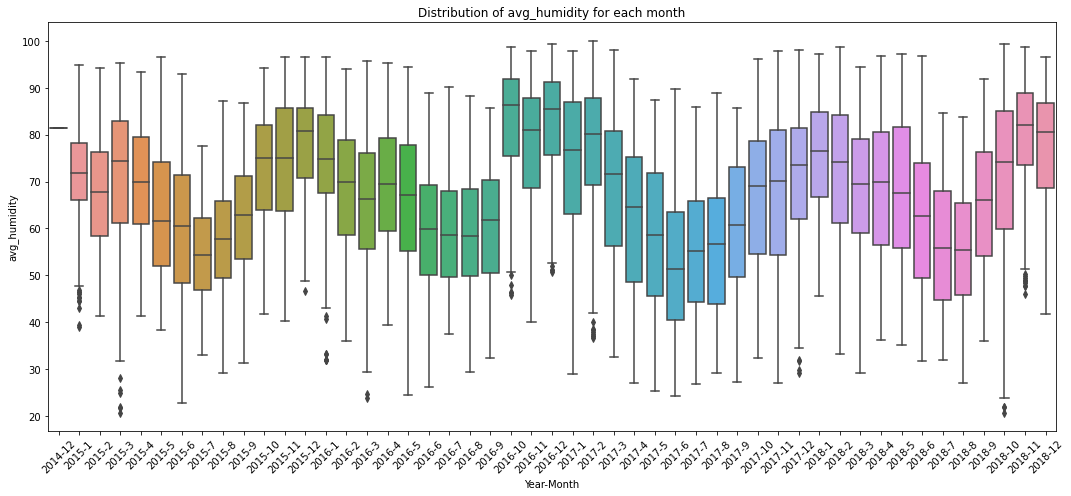

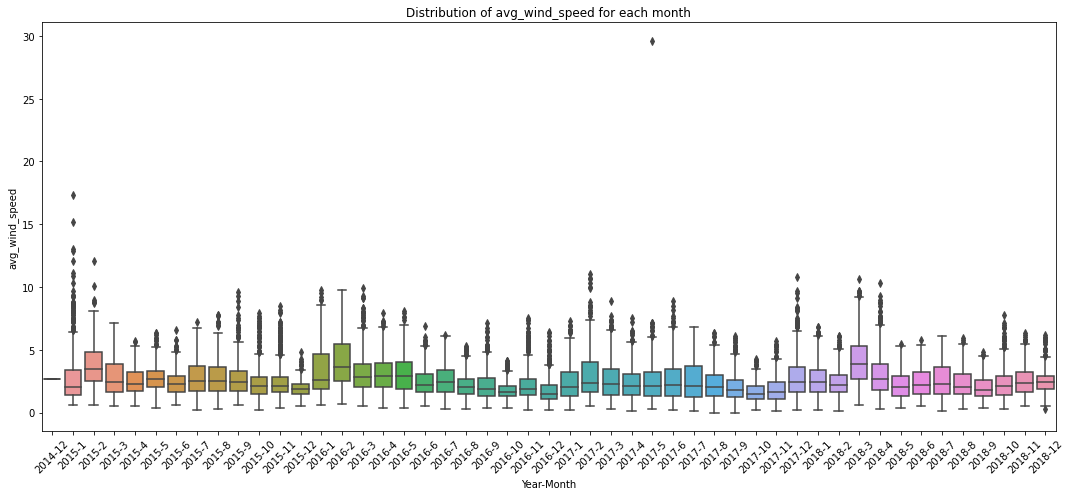

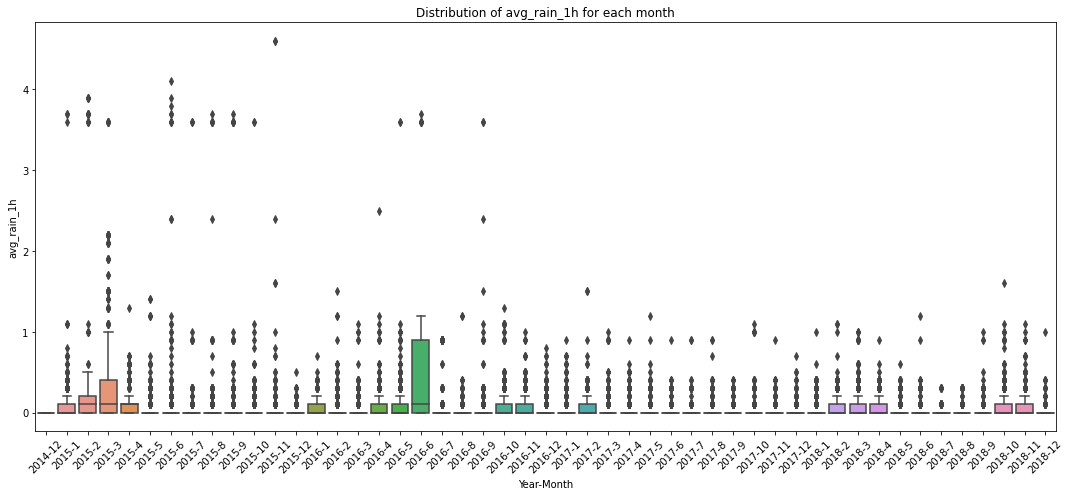

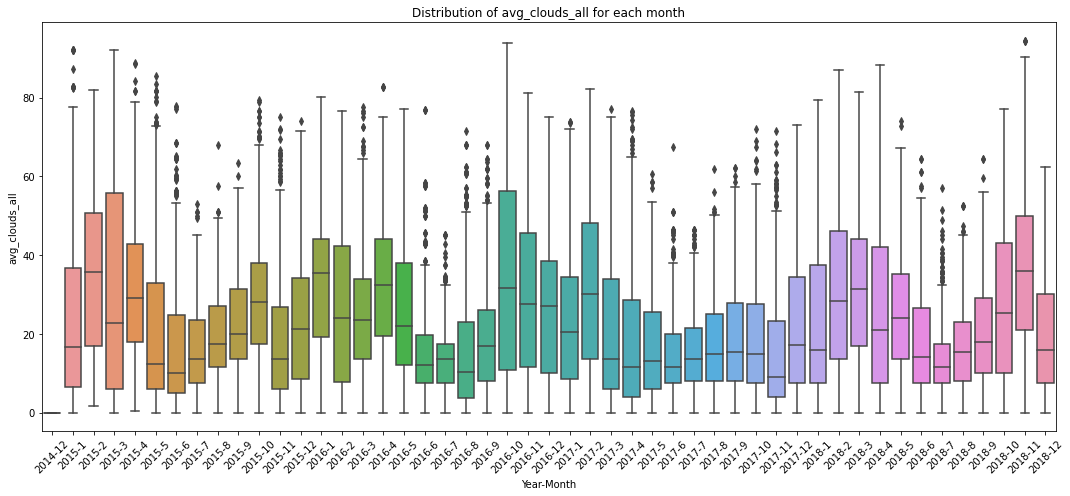

In [4]:
target_columns = ["total load actual", "generation solar", "generation wind onshore"]
exo_columns = ["avg_temp", "avg_humidity", "avg_wind_speed", "avg_rain_1h", "avg_clouds_all"]
all_columns = ["total load actual", "generation solar", "generation wind onshore", "avg_temp", "avg_humidity", "avg_wind_speed", "avg_rain_1h", 
               "avg_clouds_all"]

for column in all_columns:
    plt.figure(figsize=(15, 7))
    
    sns.lineplot(x=df_month_grouped["year_month"], y=df_month_grouped[column], label=column)
    
    plt.xticks(rotation=45)
    plt.title(f"Monthly Averaged {column}")
    plt.xlabel("Year-Month")
    plt.ylabel("Average Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

for column in all_columns:
    plt.figure(figsize=(15, 7))
    
    sns.boxplot(x=df["year_month"], y=df[column])
    
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {column} for each month")
    plt.xlabel("Year-Month")
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


<h3>Monthly average heat maps</h3>

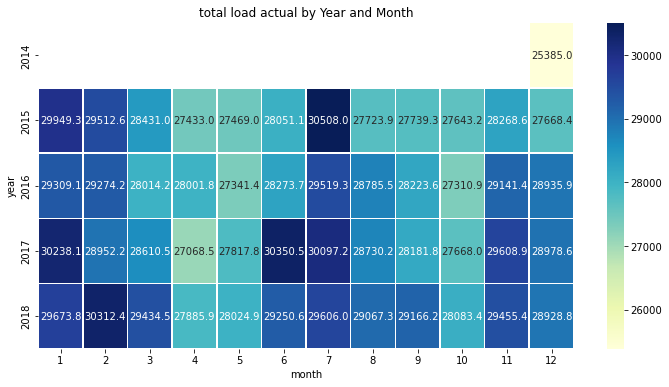

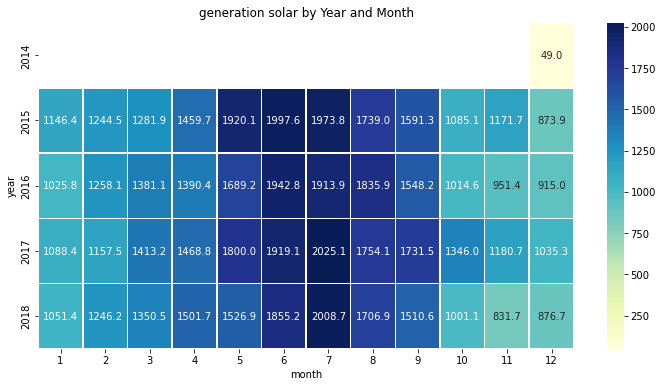

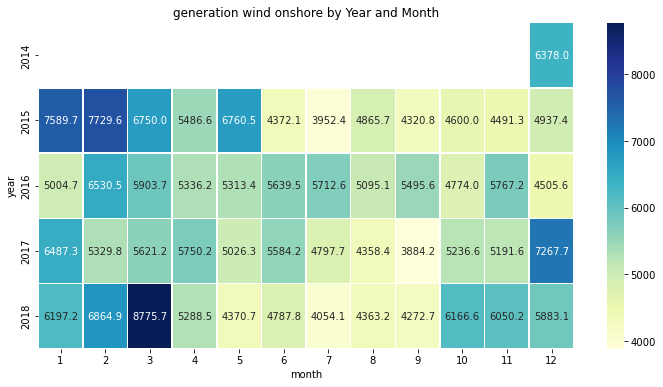

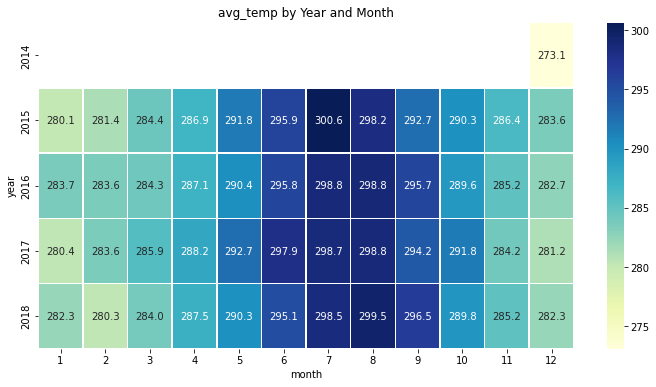

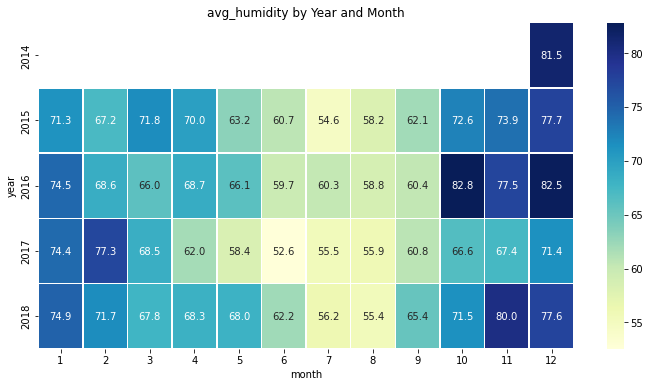

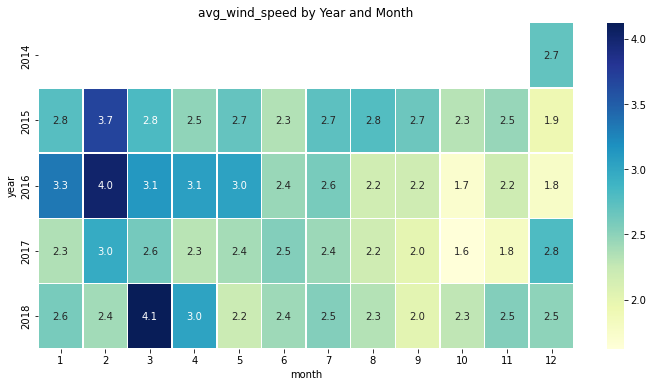

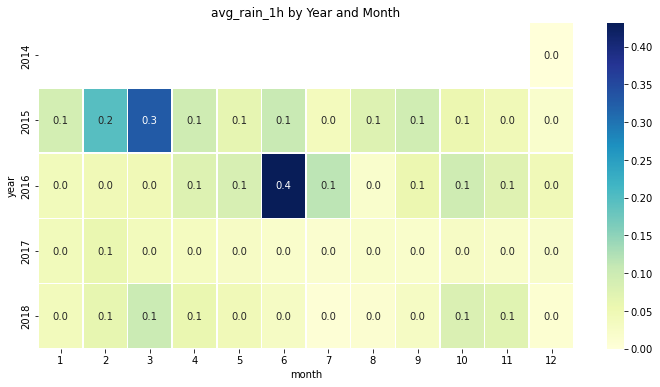

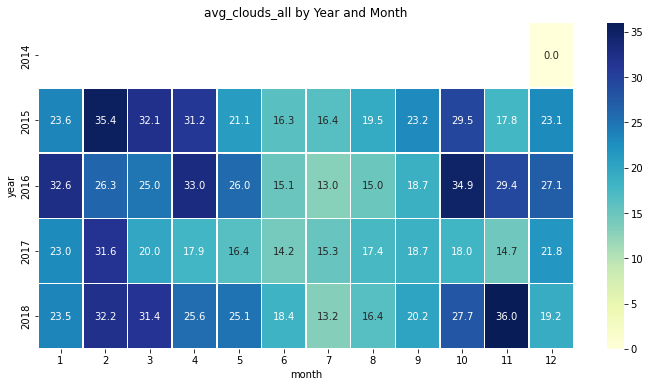

In [5]:
#exo_columns = ["avg_temp", "avg_humidity", "avg_wind_speed", "avg_rain_1h", "avg_clouds_all"]

for column in all_columns:
    heatmap_data = df_month_grouped.pivot("year", "month", column)

    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f", linewidths=.5)
    plt.title(f"{column} by Year and Month")
    plt.show()
    print("\n")


<h3>Rolling averages</h3>

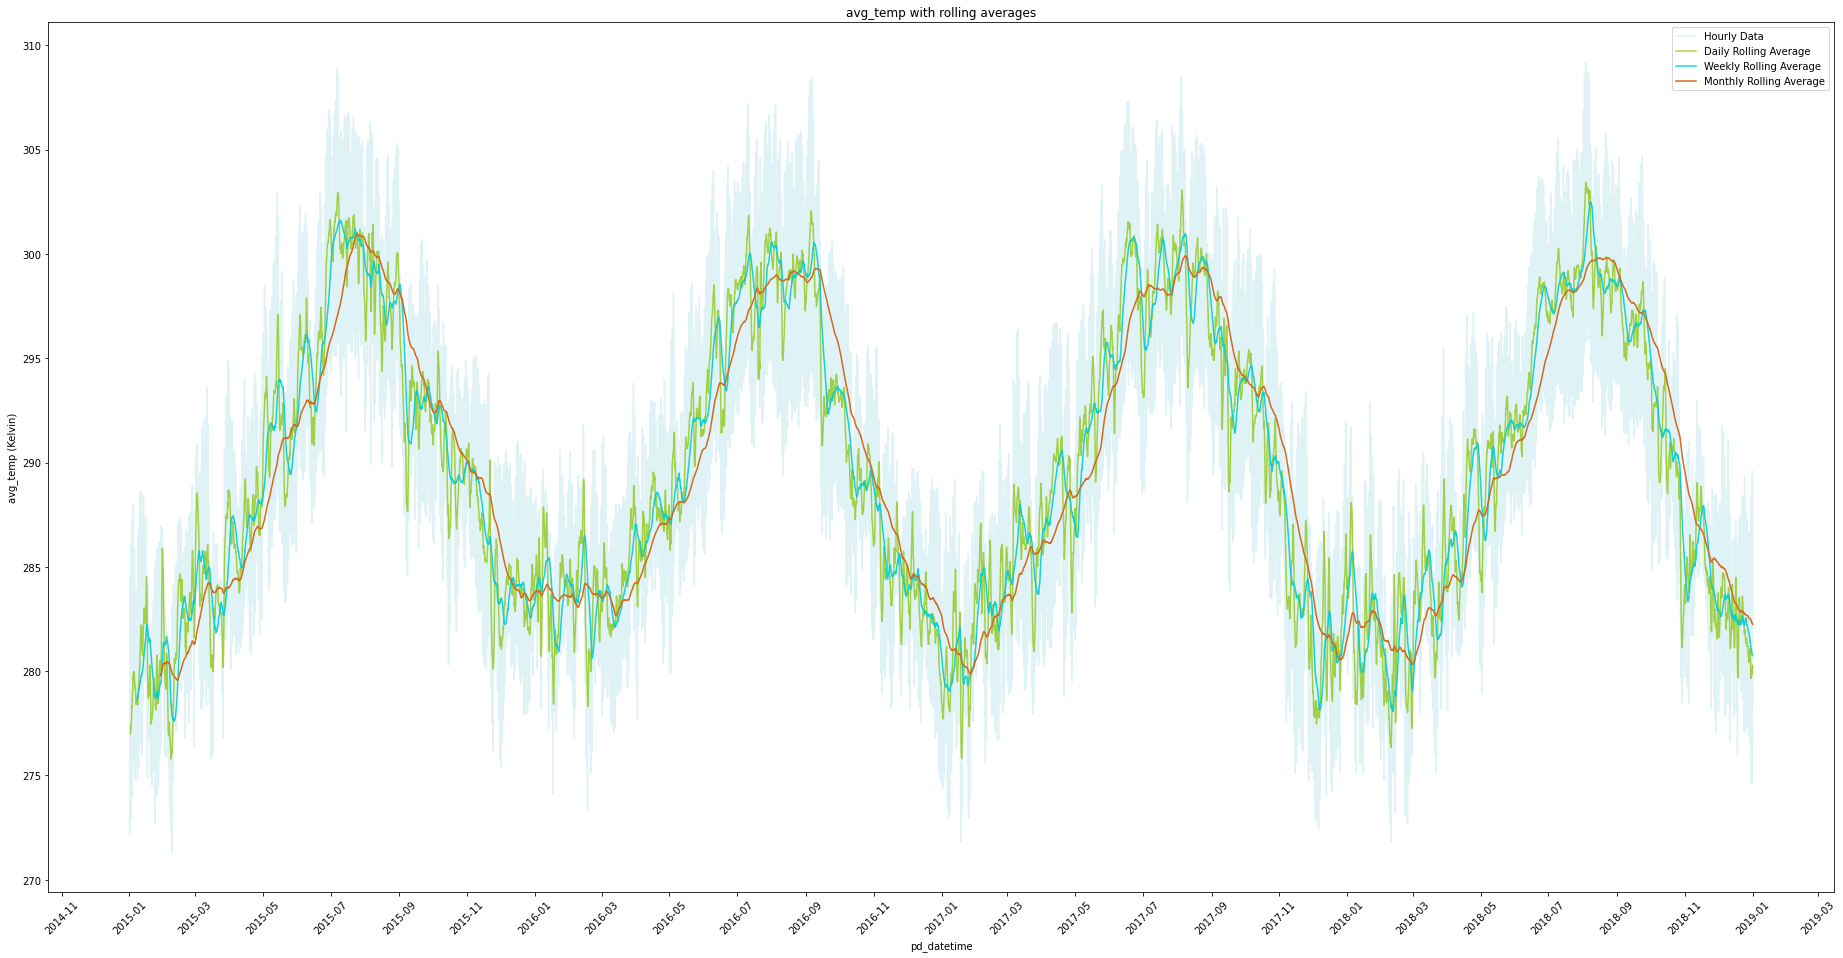

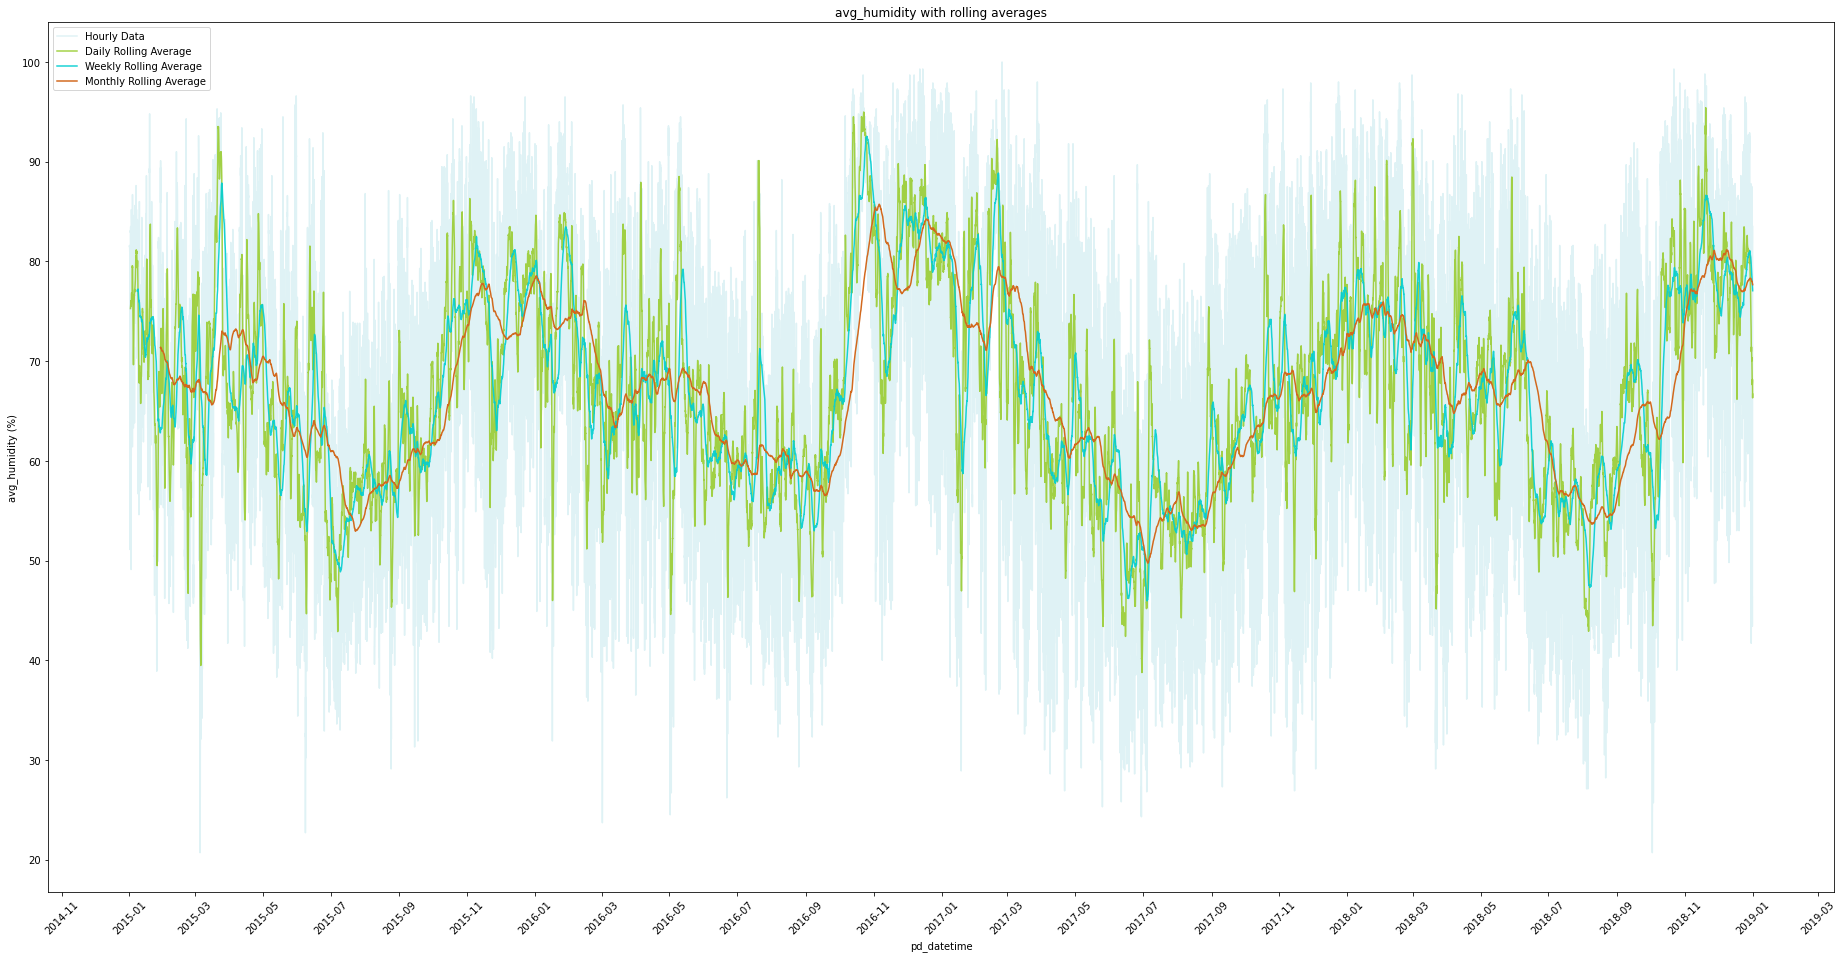

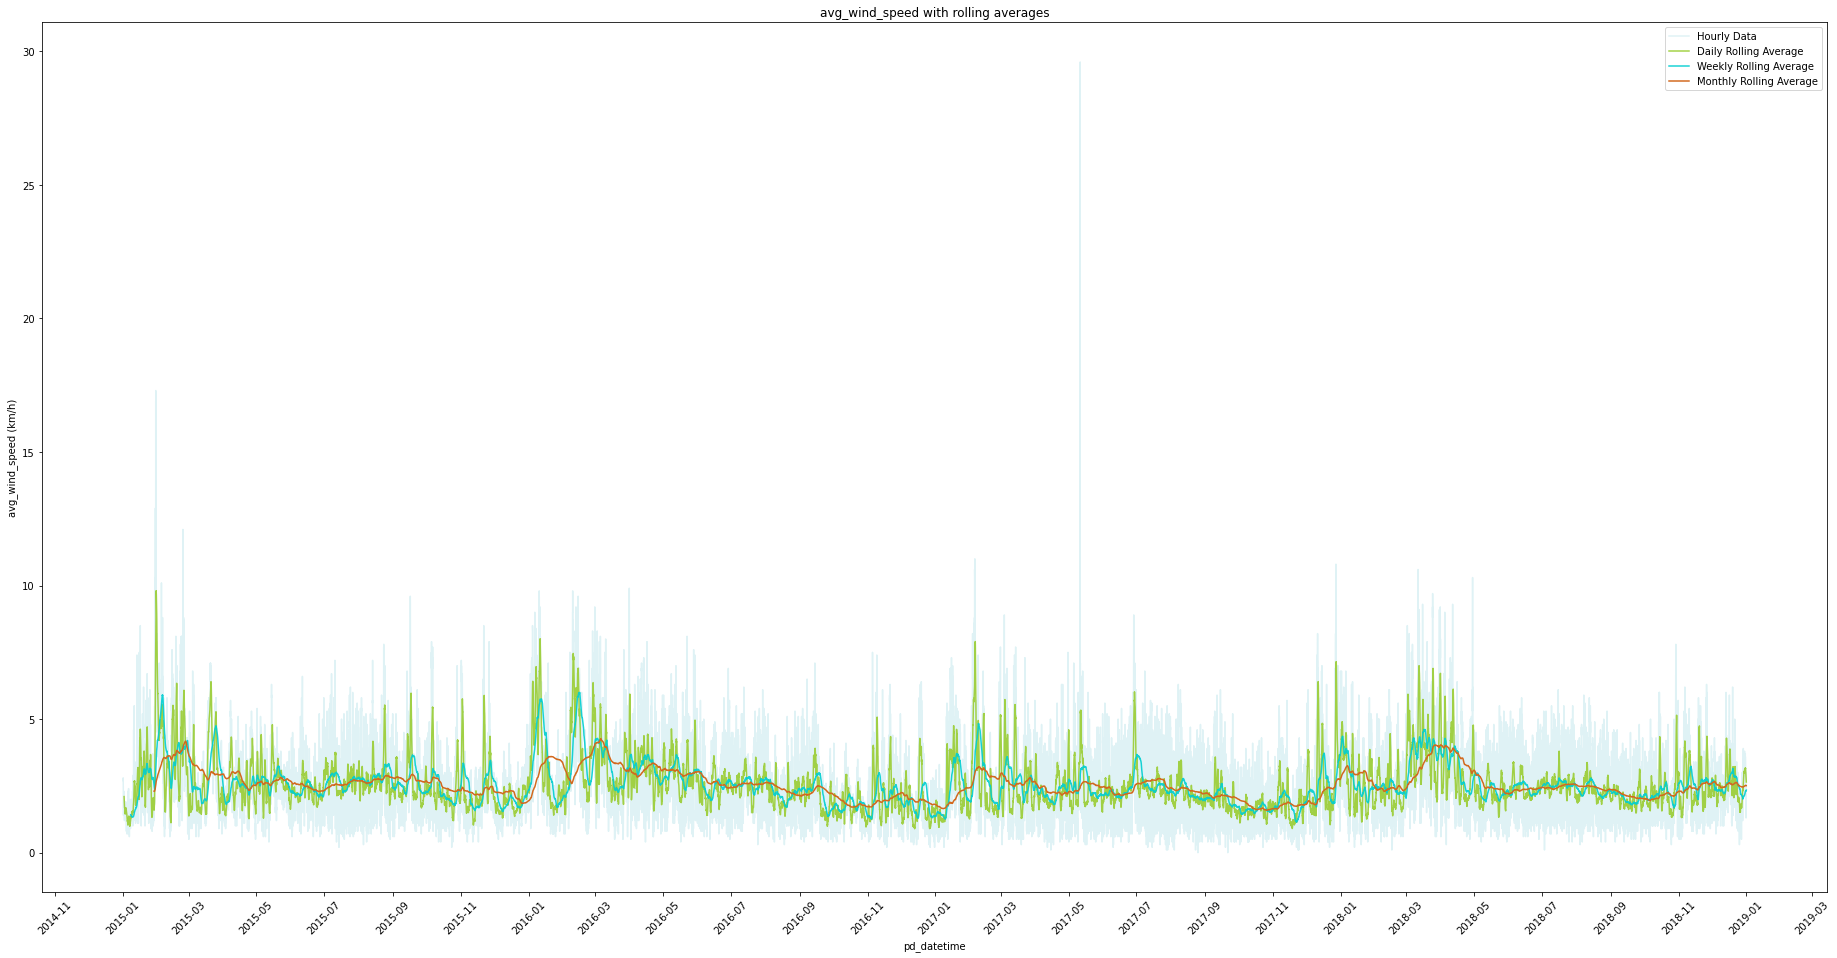

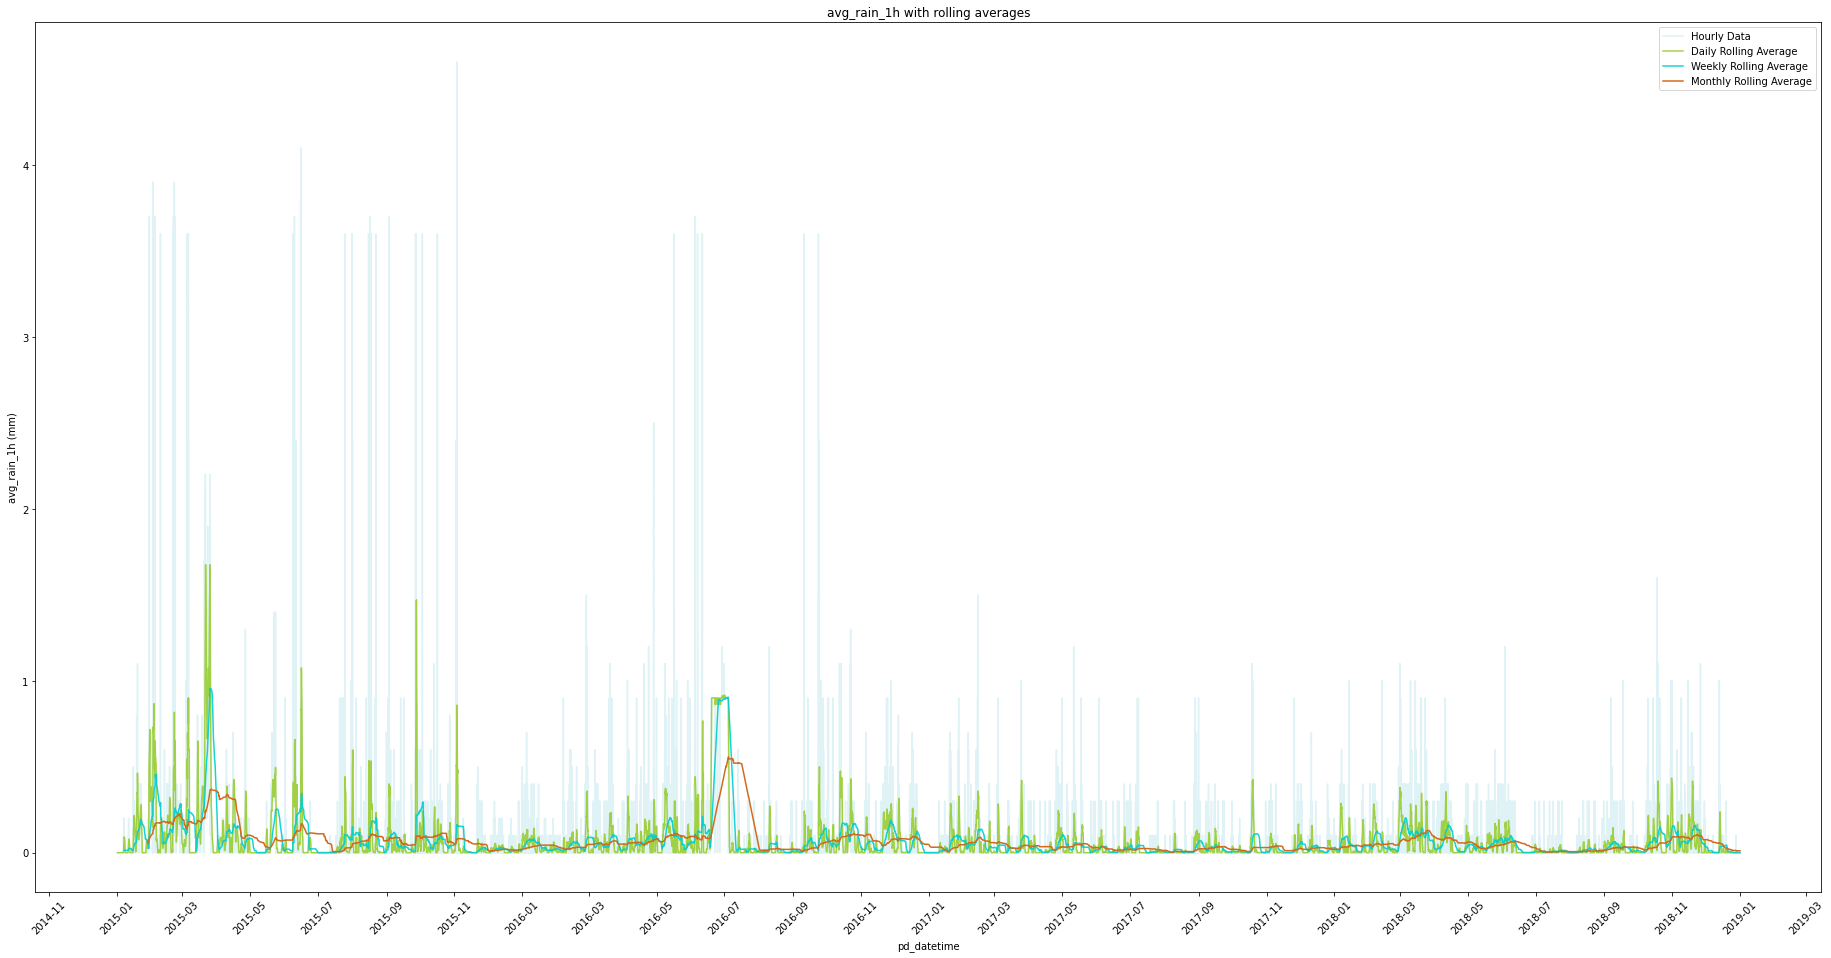

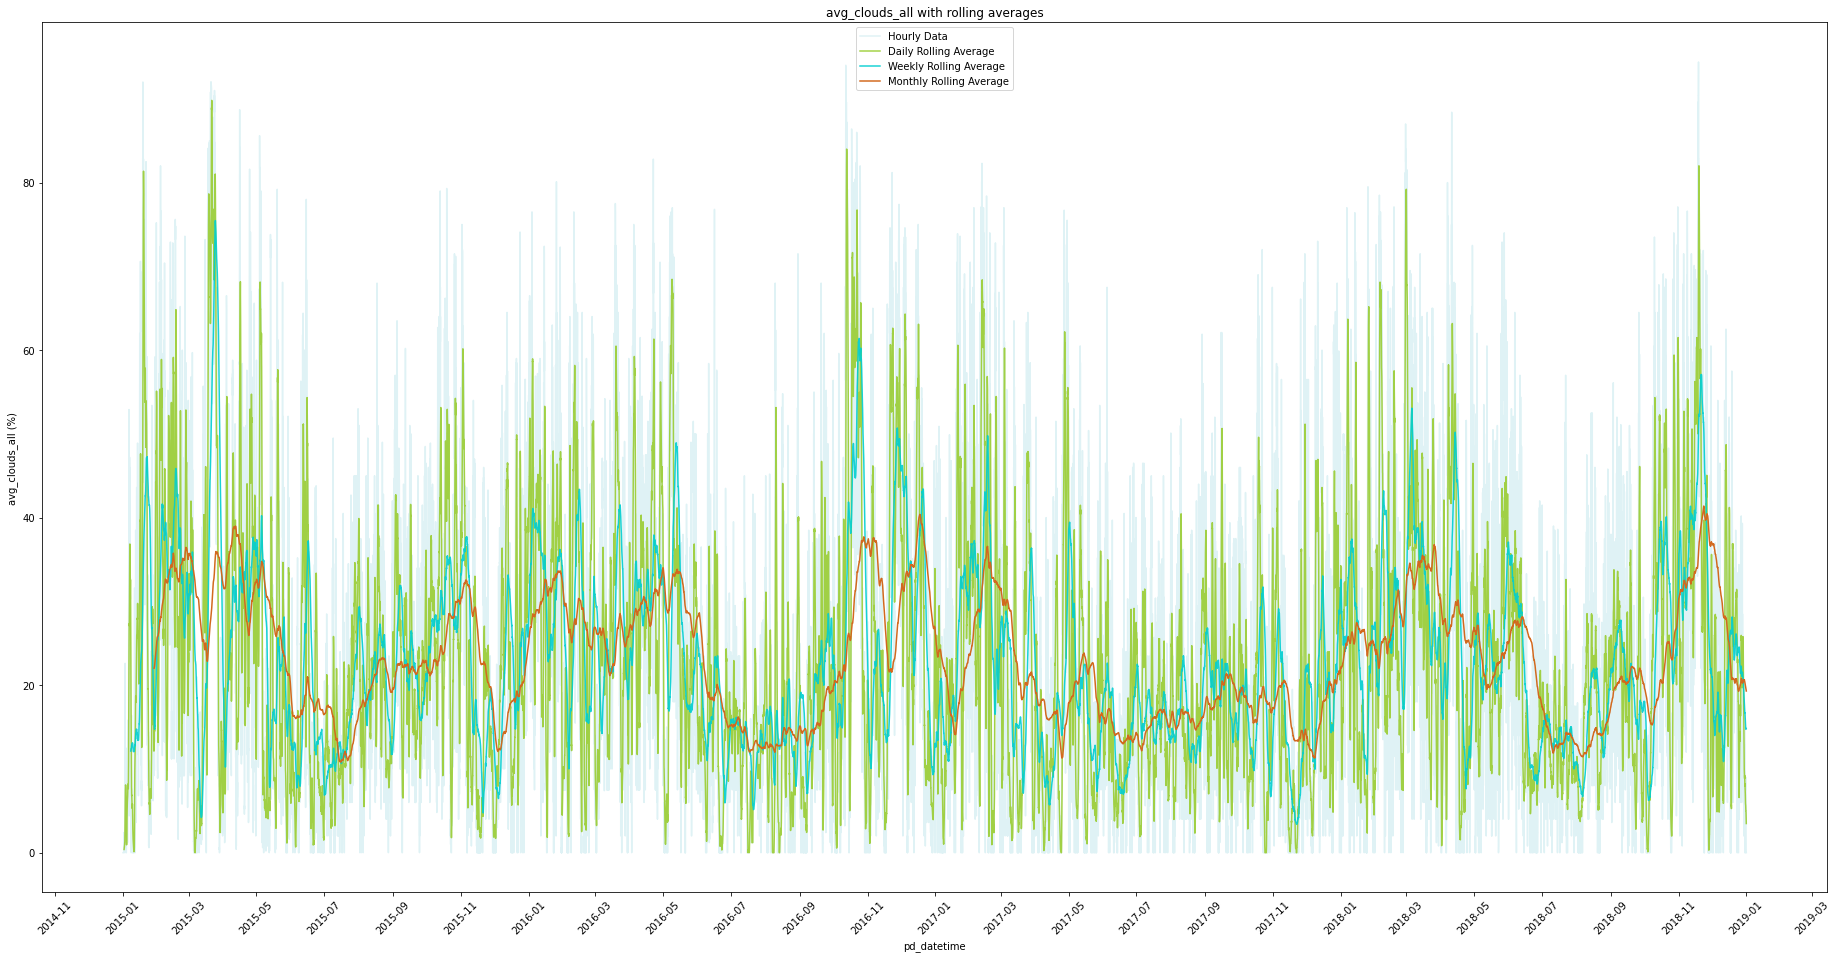

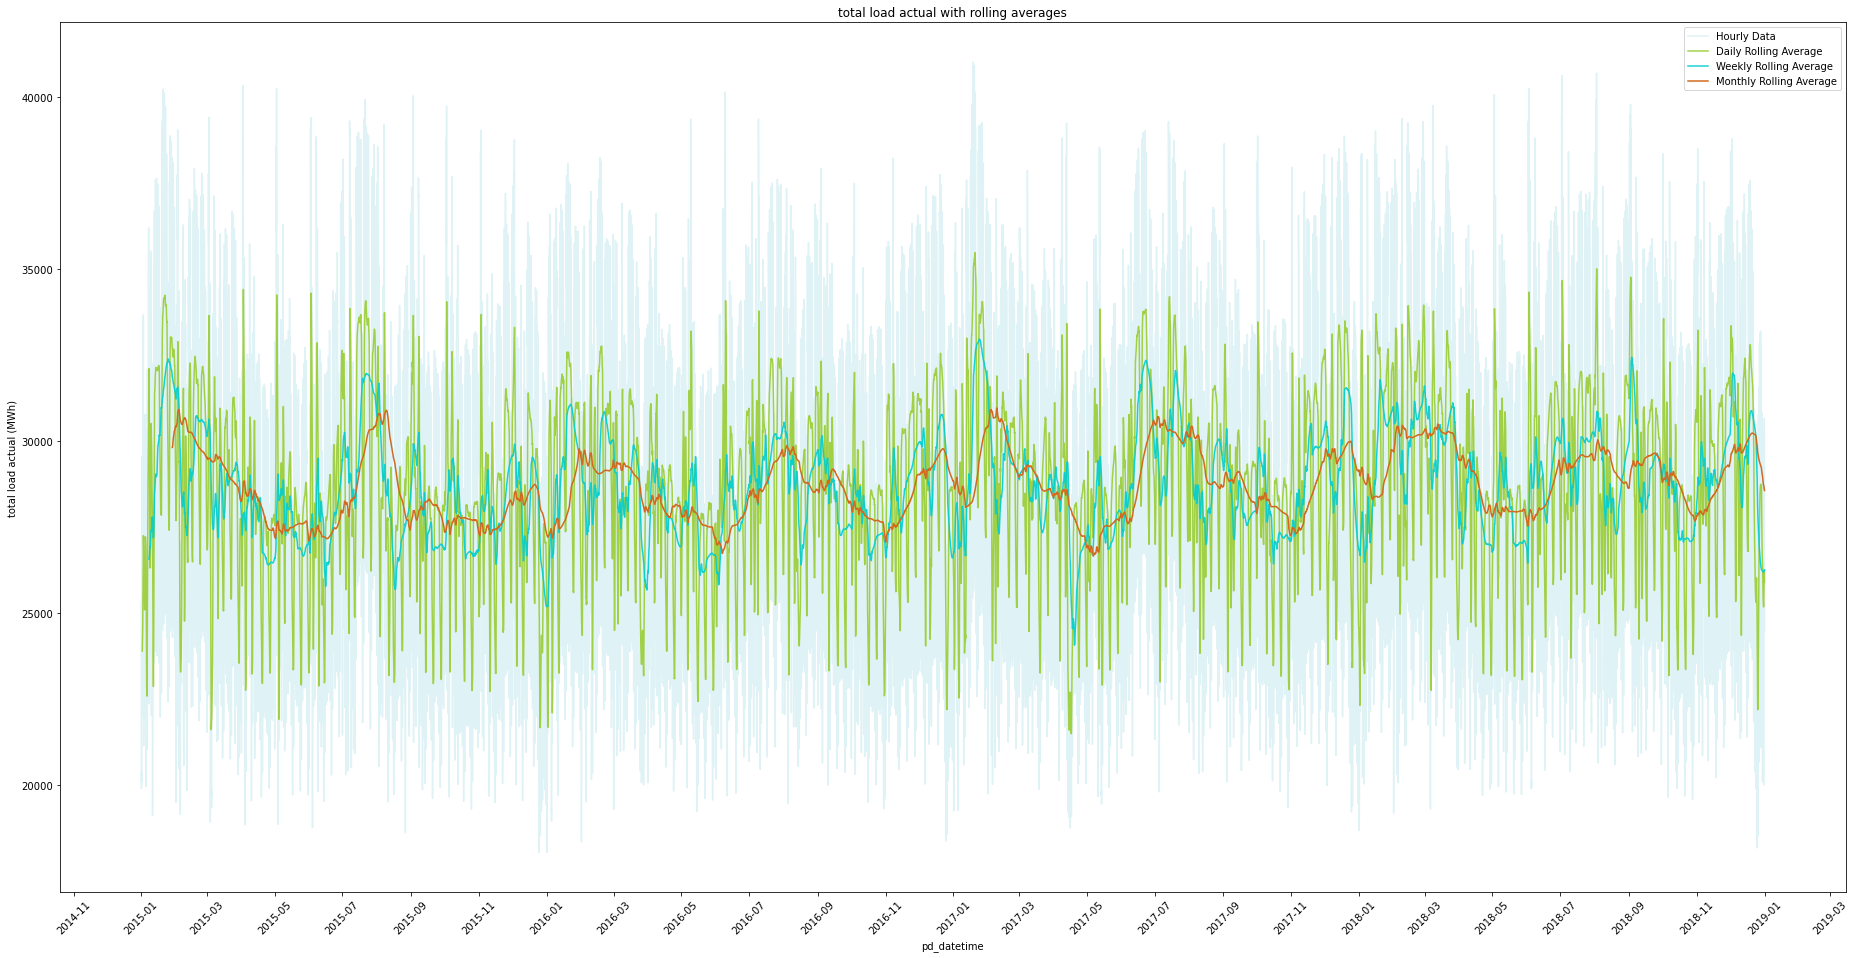

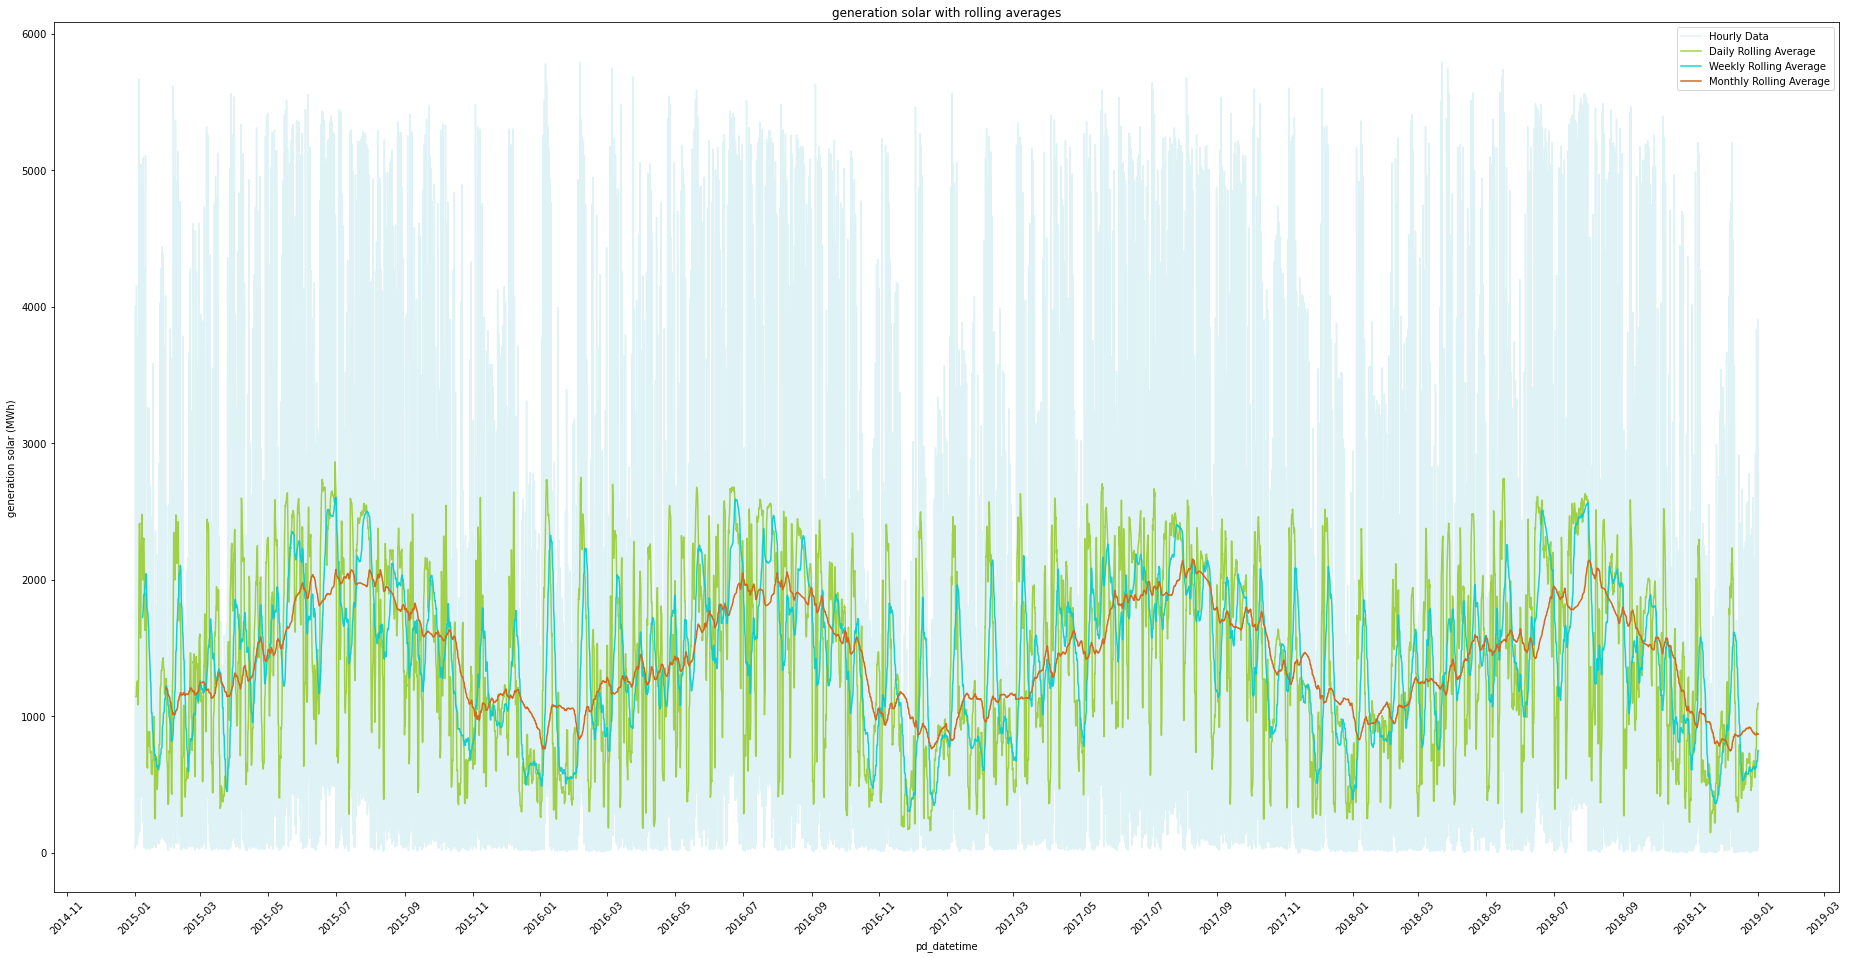

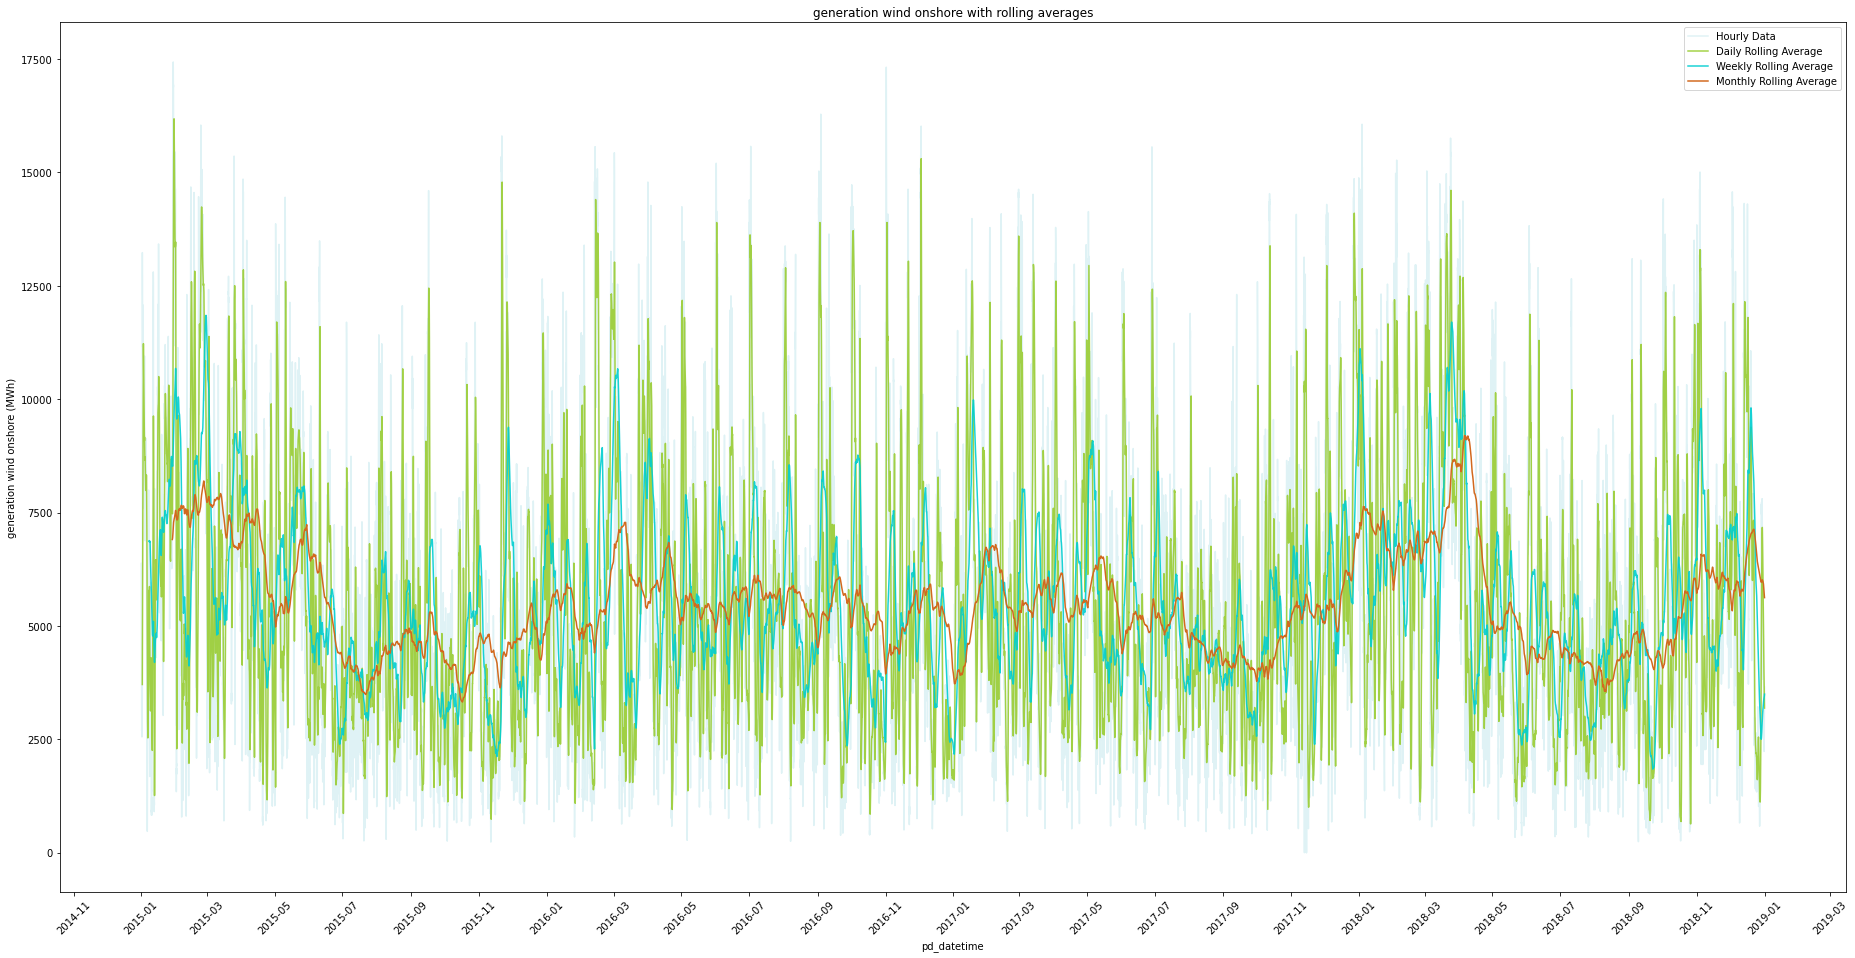

In [6]:
# exo_columns_full also includes units for each column:
columns_full = [["avg_temp", "Kelvin"], ["avg_humidity", "%"], ["avg_wind_speed", "km/h"], 
                    ["avg_rain_1h", "mm"], ["avg_clouds_all", "%"], ["total load actual", "MWh"], 
               ["generation solar", "MWh"], ["generation wind onshore", "MWh"]]

def plot_rolling_averages(dataframe, column, save_format=None):
    dataframe["daily_rolling"] = dataframe[column[0]].rolling(window=24).mean()
    dataframe["weekly_rolling"] = dataframe[column[0]].rolling(window=24*7).mean()
    dataframe["monthly_rolling"] = dataframe[column[0]].rolling(window=24*7*4).mean()

    plt.figure(figsize=(32, 16))
    sns.lineplot(data=dataframe, x=dataframe.index, y=column[0], label="Hourly Data", alpha=0.4, color="#B0E0E6")
    sns.lineplot(data=dataframe, x=dataframe.index, y="daily_rolling", label="Daily Rolling Average", 
                 alpha=0.9, color="#9ACD32")
    sns.lineplot(data=dataframe, x=dataframe.index, y="weekly_rolling", label="Weekly Rolling Average", alpha=0.9,
                color="#00CED1")
    sns.lineplot(data=dataframe, x=dataframe.index, y="monthly_rolling", label="Monthly Rolling Average",
                color="#D2691E")
    plt.title(f"{column[0]} with rolling averages")
    plt.ylabel(f"{column[0]} ({column[1]})")  # (Displaying units on the y-axis)

    # Setting the x-axis to show year-month rather than how many hours since start:
    #REF: https://matplotlib.org/stable/api/dates_api.html
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Displaying every second month 
    #REF: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
    plt.xticks(rotation=45) # (Rotating x-axis labels for better readability)

    plt.legend()

    if save_format == "pdf":
        plt.savefig(f"{column[0]}_rolling_averages.pdf", format='pdf', bbox_inches='tight')
    elif save_format == "png":
        plt.savefig(f"{column[0]}_rolling_averages.png", format='png', bbox_inches='tight')

    plt.show()
    print("\n")

for column in columns_full:
    plot_rolling_averages(df, column)


<h3>Computing periodograms for seasonality checks</h3>

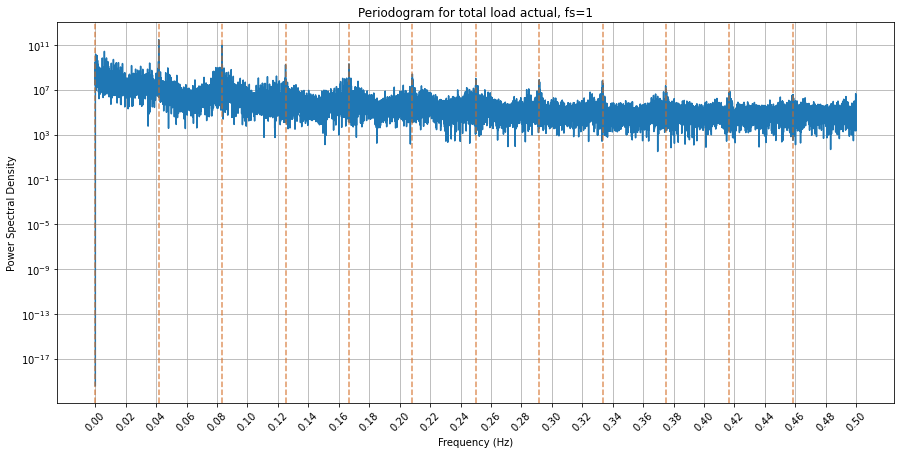

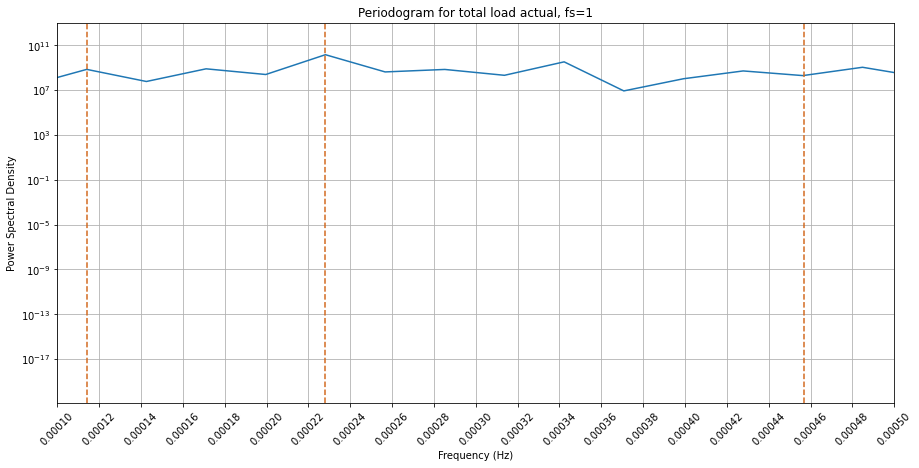

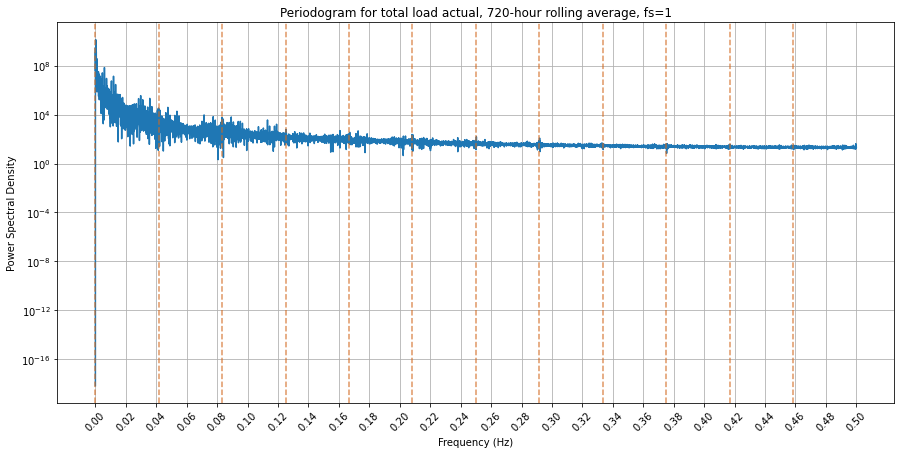

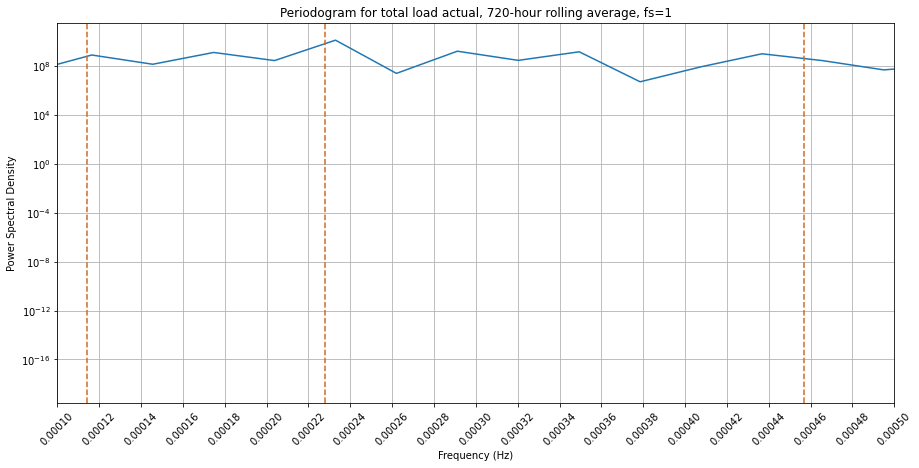

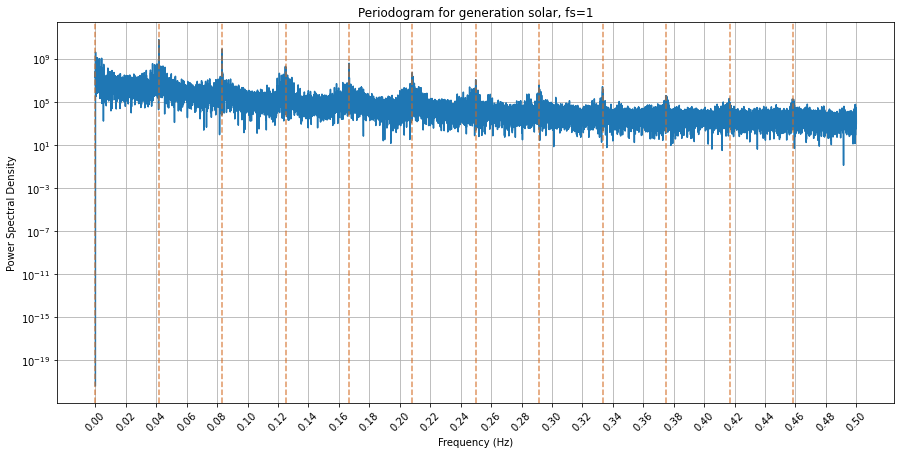

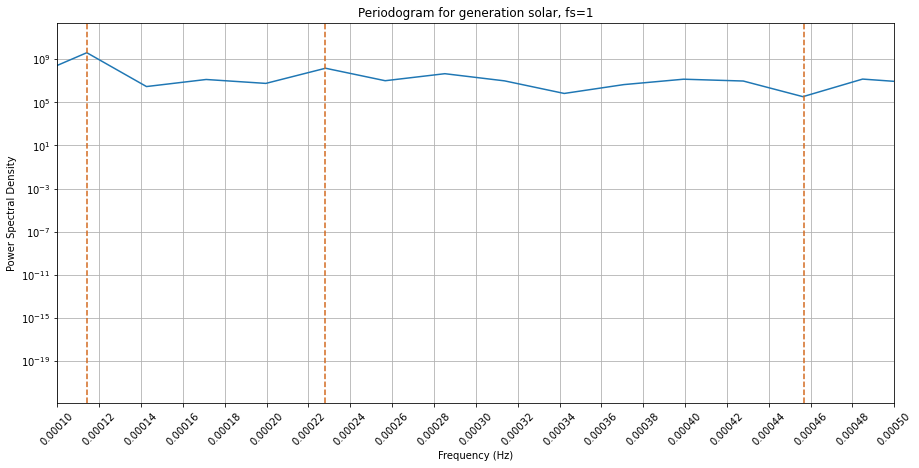

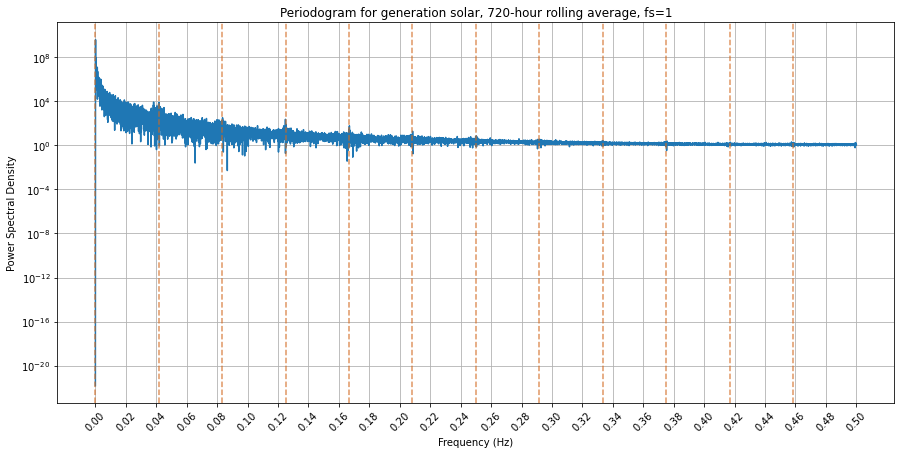

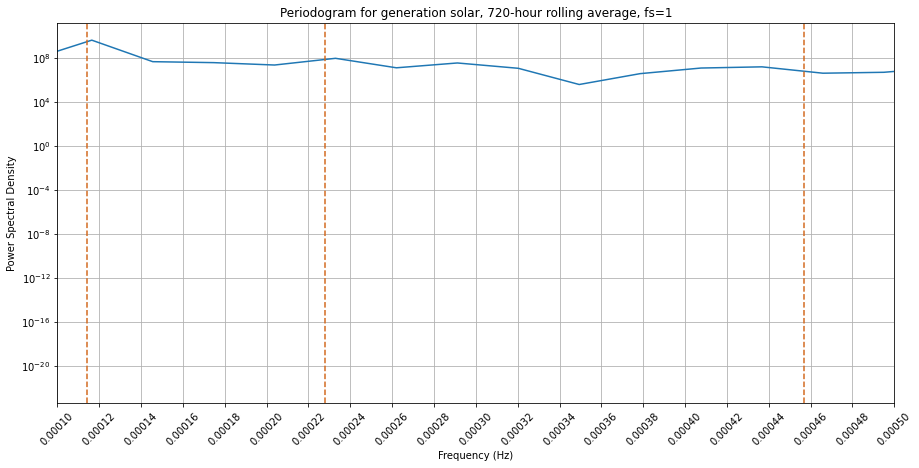

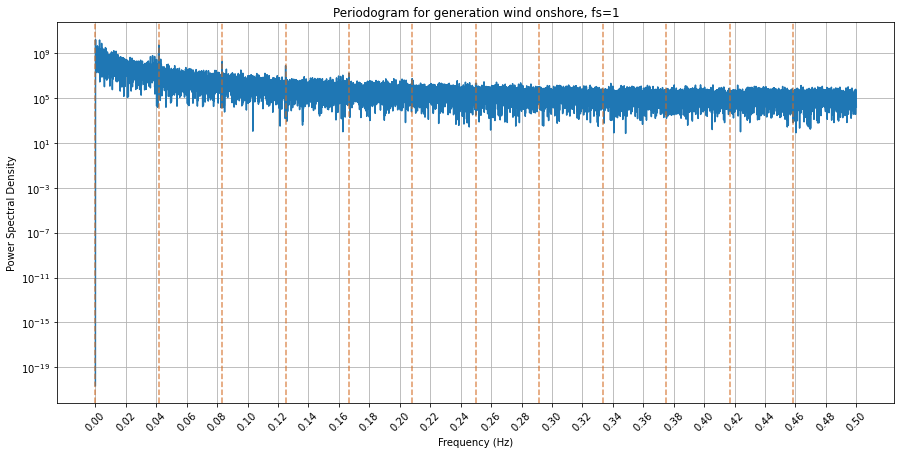

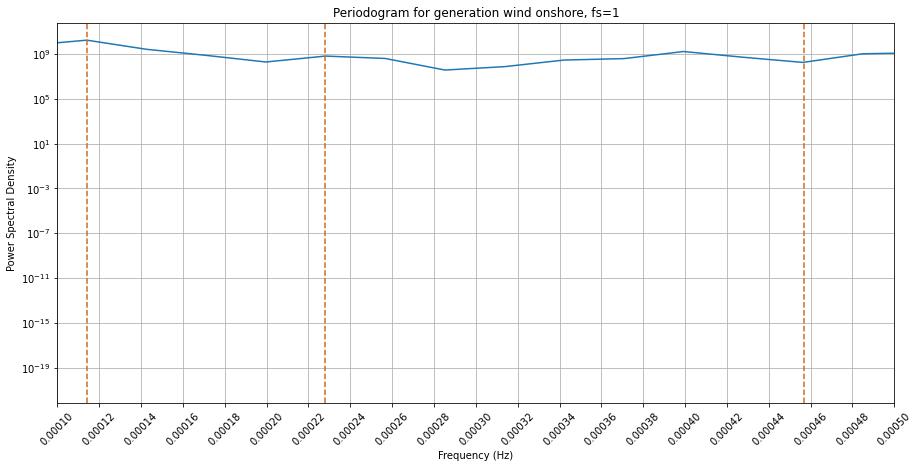

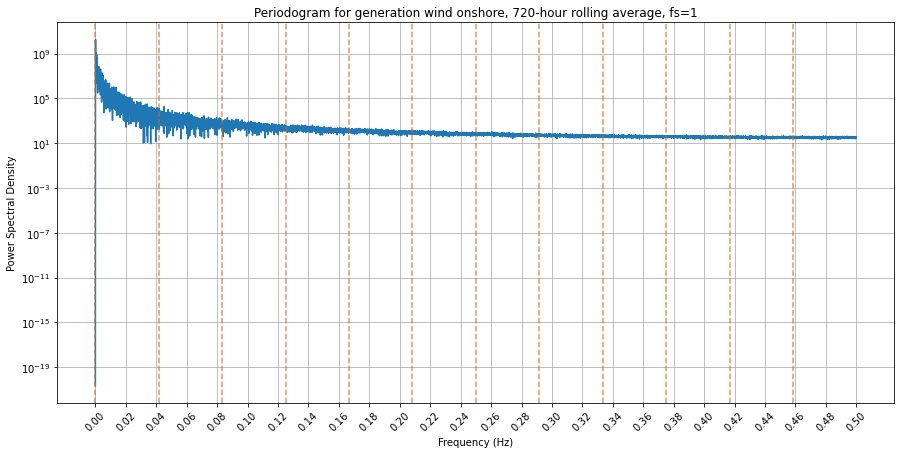

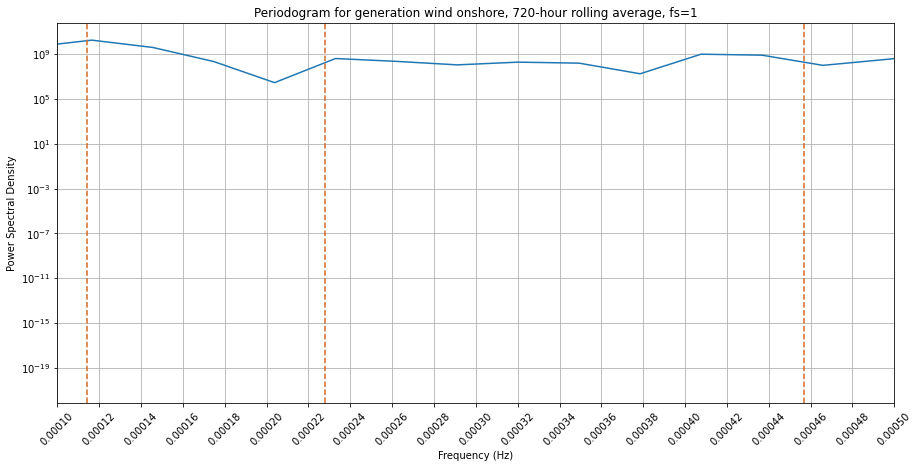

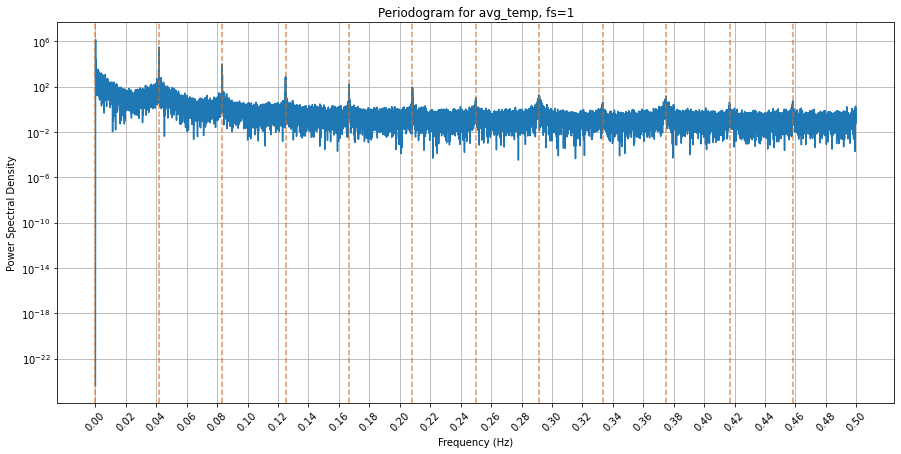

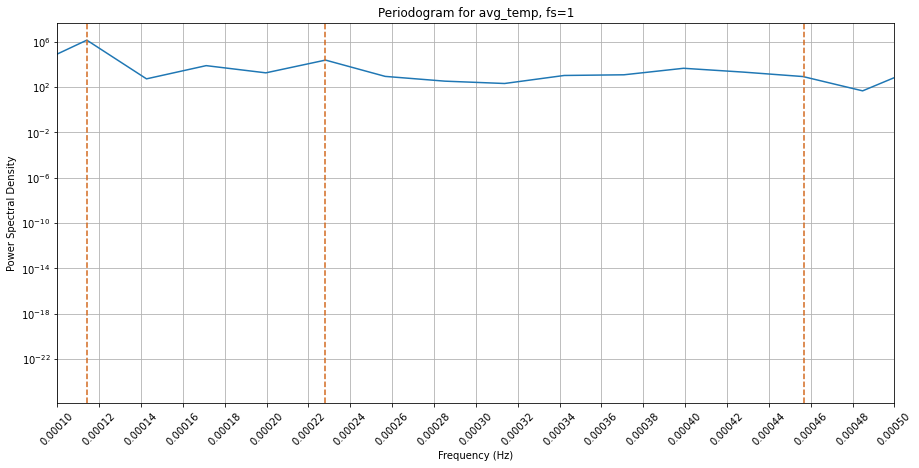

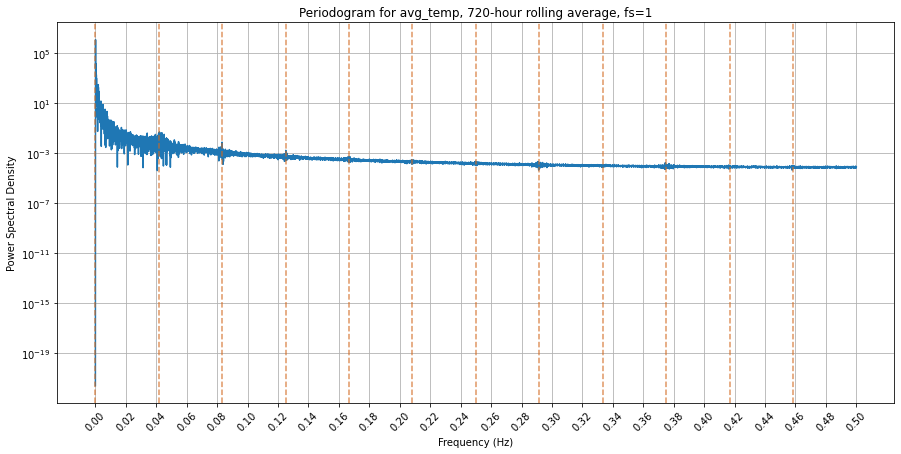

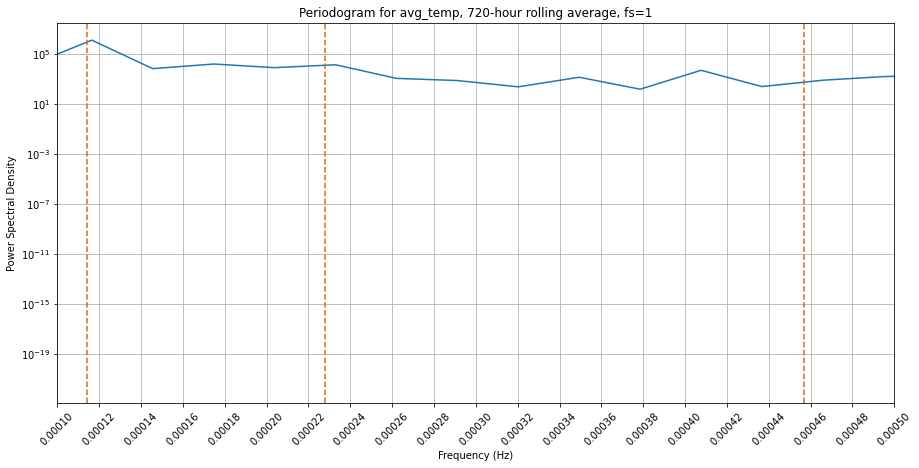

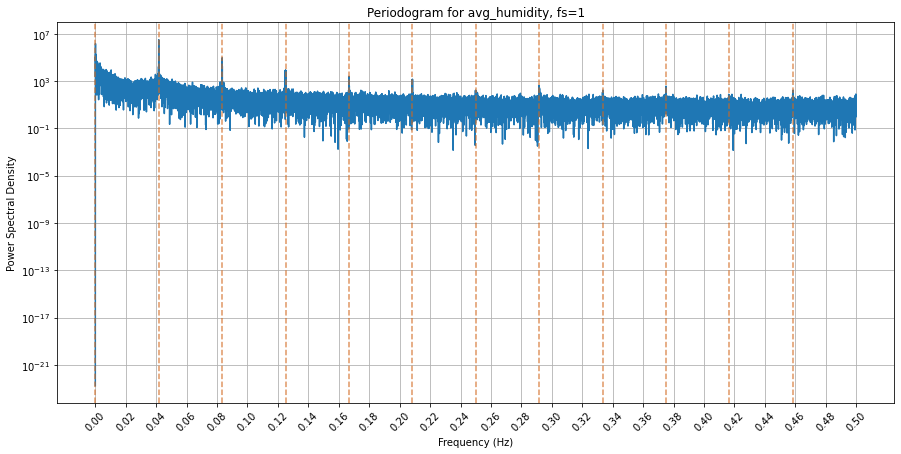

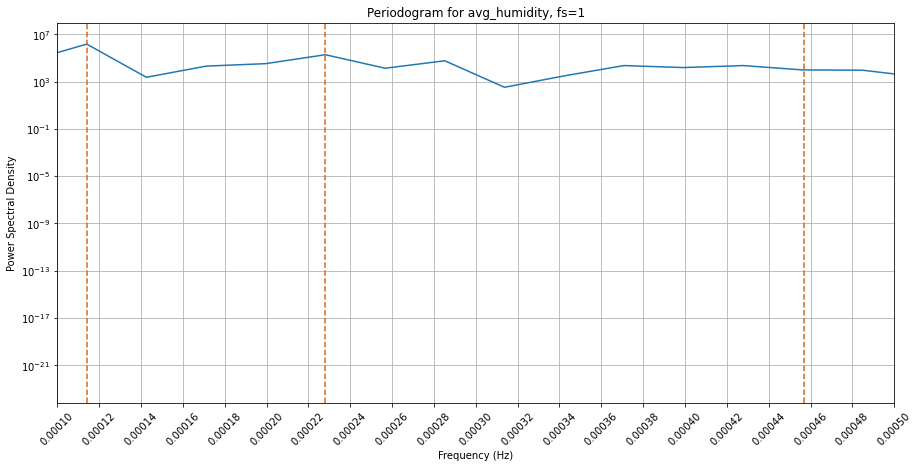

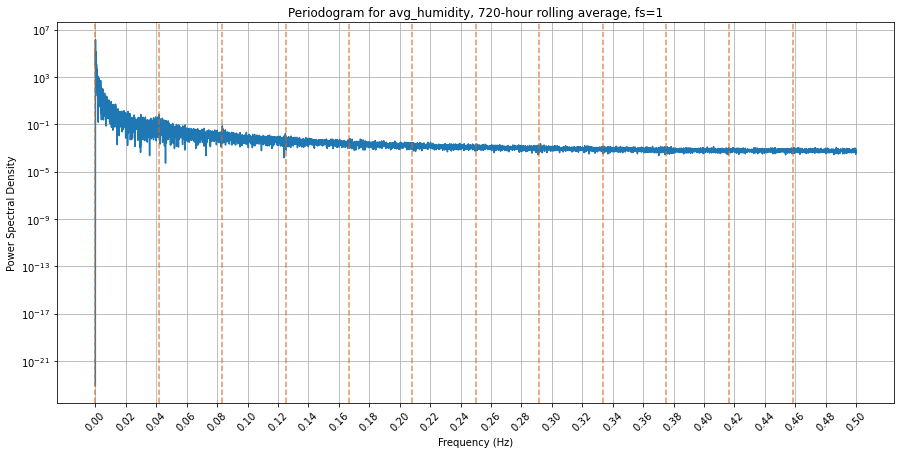

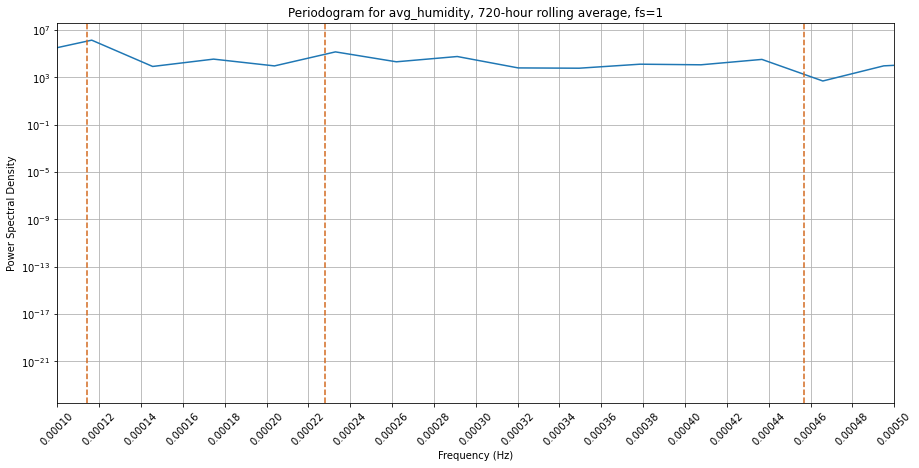

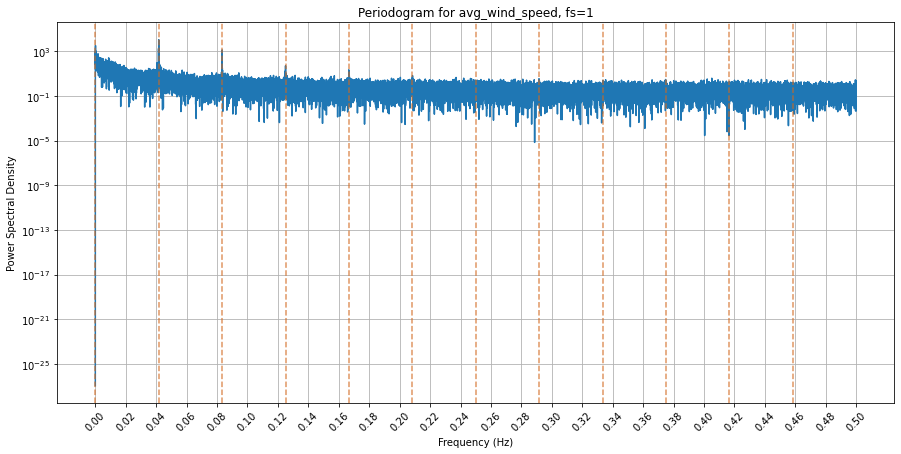

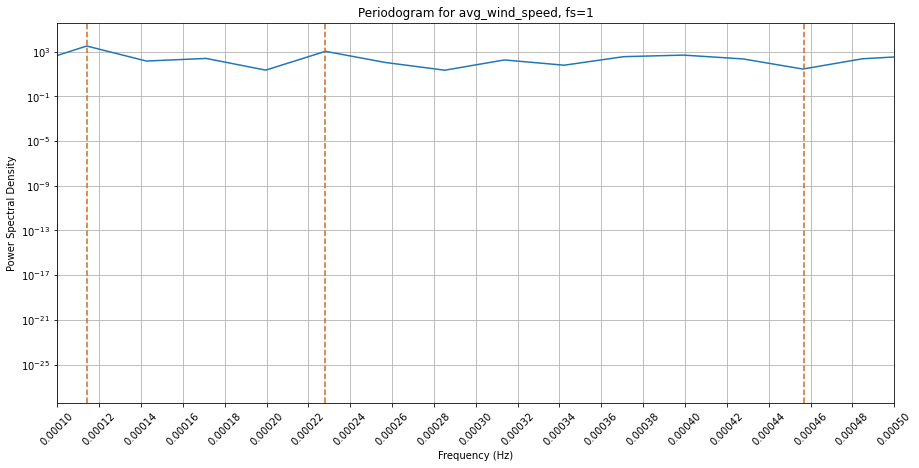

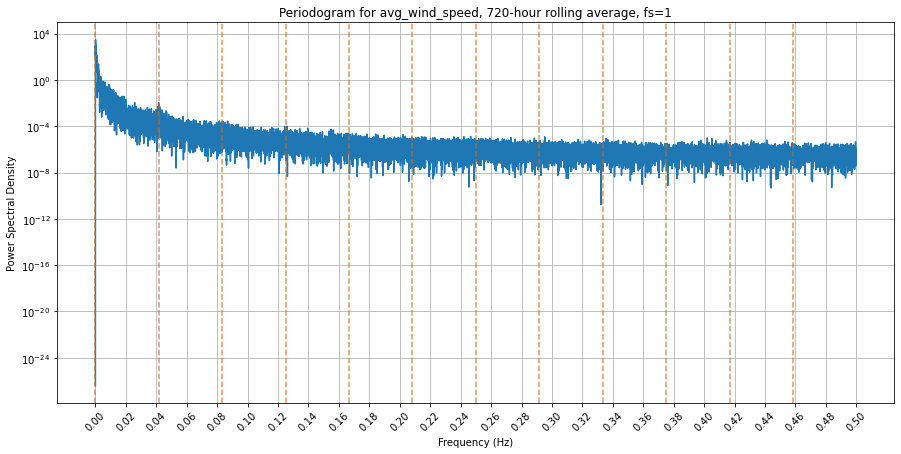

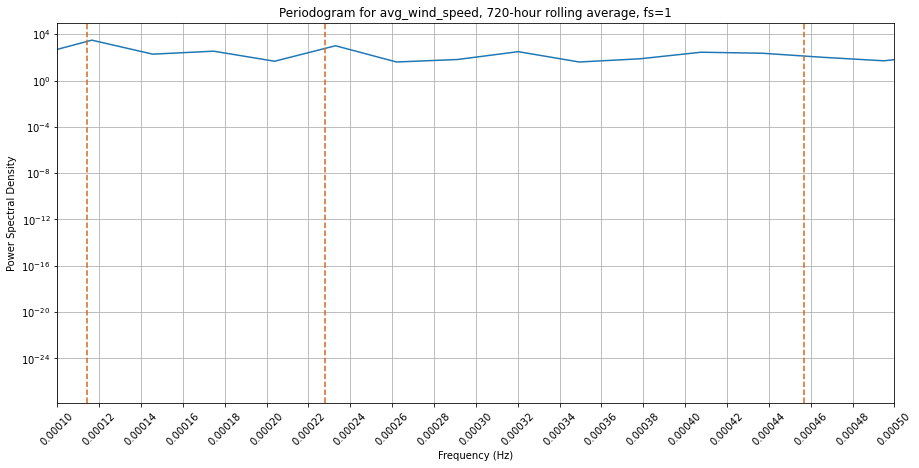

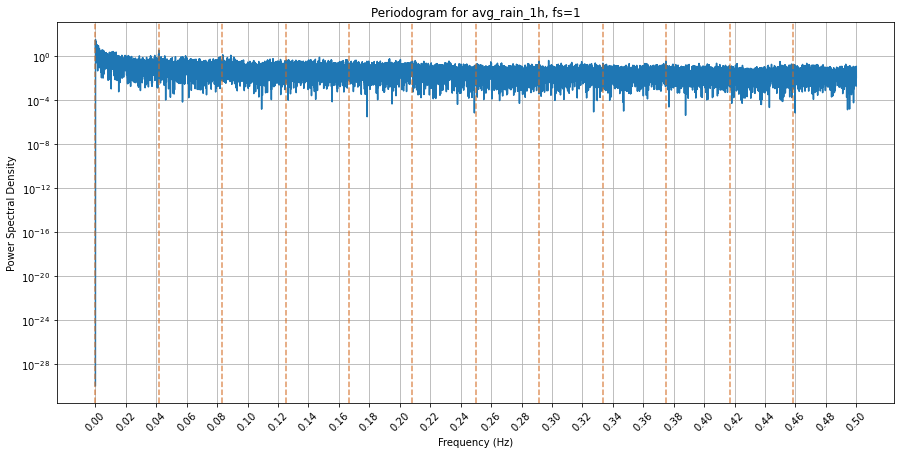

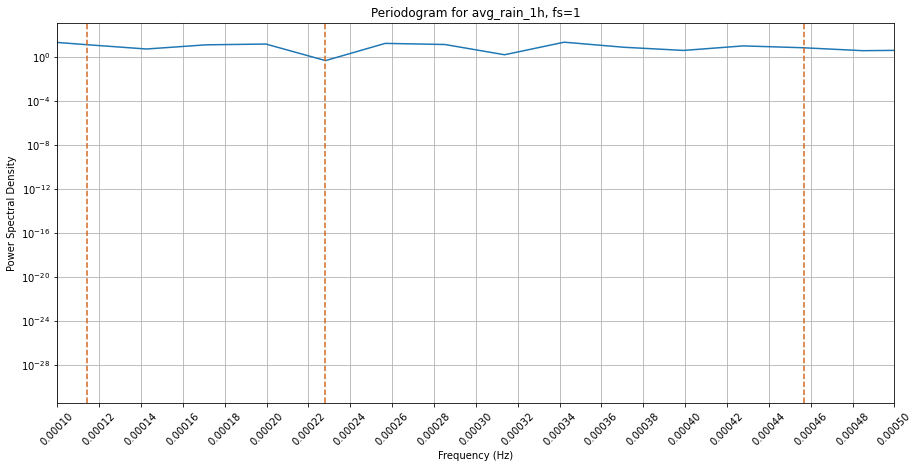

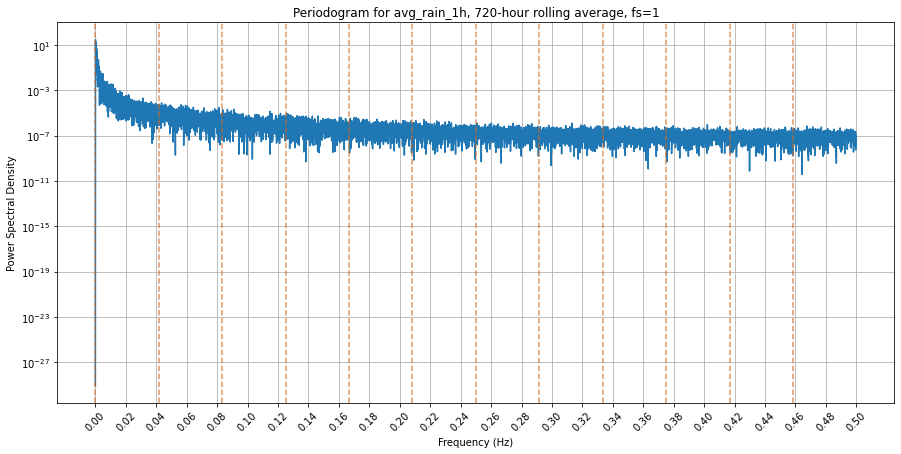

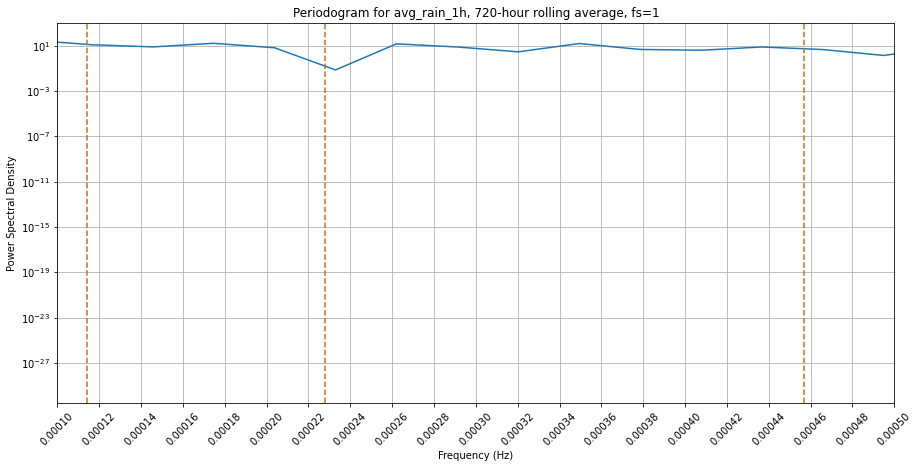

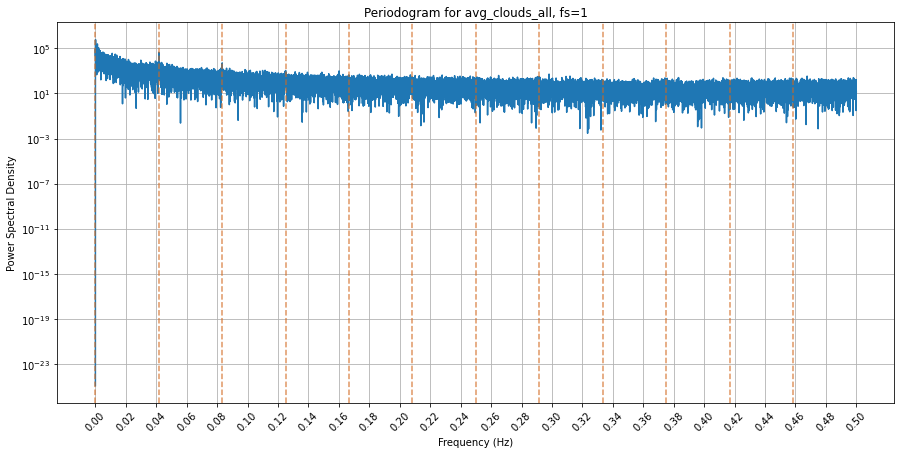

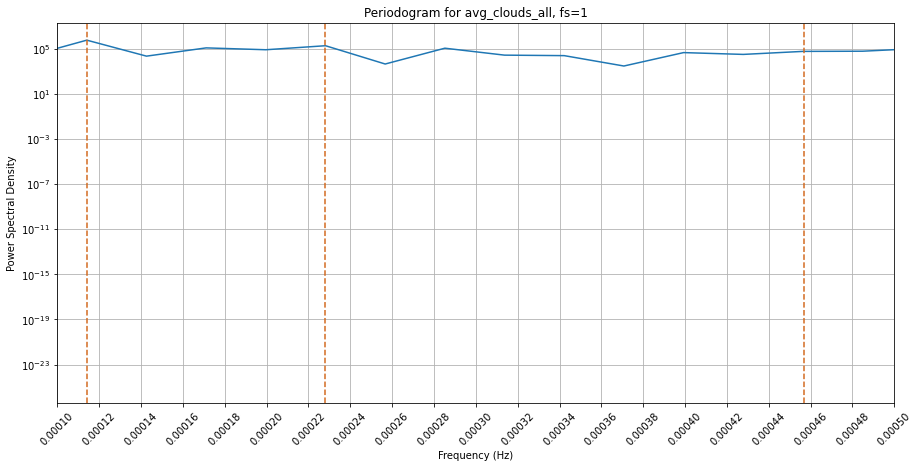

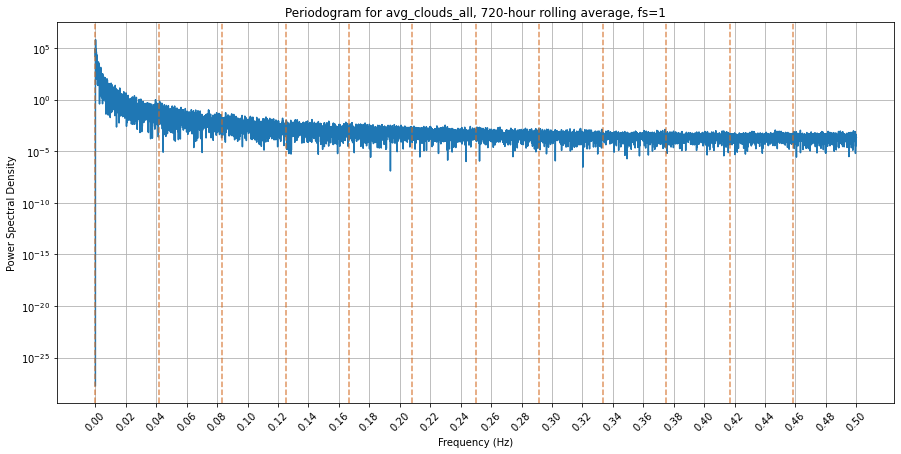

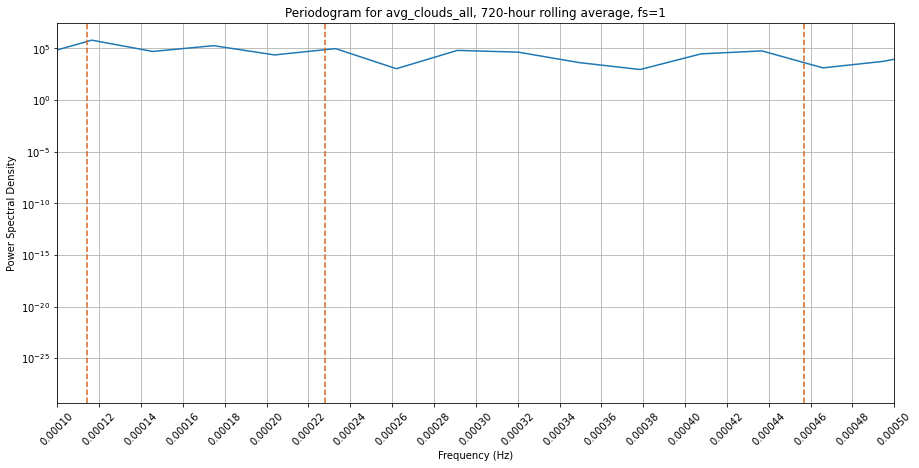

Power Values for Annual Cycles:




Power Values for Daily Cycles:




Key
---------------------------------------------
Power value > 10^6:          very strong
10^6 >= Power value > 10^5:  strong
10^5 >= Power value > 10^2:  significant
10^2 >= Power value > 10^1:  weak
Power value <= 10^1:         none
---------------------------------------------
Peak Quotient: The power of the signal over the mean of nearby values, for 1/8760 or 1/24.
SSF: Seasonal Significance Factor, log(Power)*(Peak Quotient)




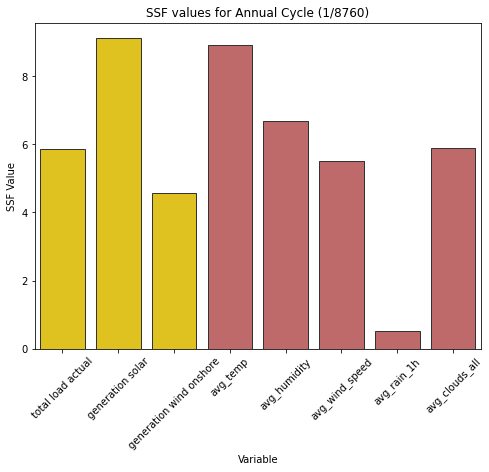

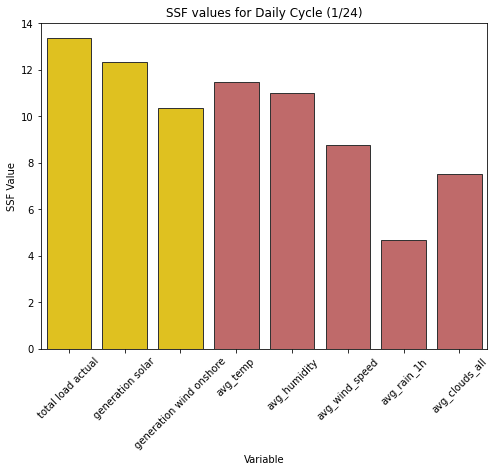

In [7]:
# Refactored code with separated functions for more modular approach that is easier to debug:  

def compute_periodogram(time_series, column_name, fs=1/8760, rolling_avg_window=None, 
                       peak_quotient_factor=0.2):
    # peak_quotient_factor: the proportion of the frequency from which it will be measured against,
    # ... to determine how prominent the peak is vs other peaks around it. 
    if rolling_avg_window:
        time_series = time_series.rolling(window=rolling_avg_window).mean().dropna()

    frequencies, power = periodogram(time_series)
    
    indexes = {
        "1/8760": (np.abs(frequencies - 1/8760)).argmin(),
        "2/8760": (np.abs(frequencies - 2/8760)).argmin(),
        "4/8760": (np.abs(frequencies - 4/8760)).argmin(),
        "1/24": (np.abs(frequencies - 1/24)).argmin(),
        "2/24": (np.abs(frequencies - 2/24)).argmin()
    }

    power_values = {key: power[idx] for key, idx in indexes.items()}
    
    # I'm using frequences at +/- x% of the frequencies to gain a background level that can then be 
    # ... compared against to gain an idea of the prominence of the daily and annual peaks. 
    nearby_freqs = {
        "1/8760": [((1 - peak_quotient_factor) * 1/8760), ((1 + peak_quotient_factor) * 1/8760)],
        # peak_quotient_factor is divided by 10 for 1/24 since this is a much greater fraction.
        "1/24": [((1 - (peak_quotient_factor/10)) * 1/24), ((1 + (peak_quotient_factor/10)) * 1/24)]
    }
    nearby_idxs = {key: [(np.abs(frequencies - freq)).argmin() for freq in freqs] for key, freqs in nearby_freqs.items()}
    nearby_power_values = {key: [power[idx] for idx in idxs] for key, idxs in nearby_idxs.items()}
    
    power_peak_quotients = {
        "1/8760": power_values["1/8760"] / np.mean(nearby_power_values["1/8760"]),
        "1/24": power_values["1/24"] / np.mean(nearby_power_values["1/24"])
    }
    
    return frequencies, power, power_values, power_peak_quotients

def plot_periodogram(frequencies, power, column_name, fs=1/8760, annual_values_magnify=False, rolling_avg_window=None):
    plt.figure(figsize=(15,7))
    plt.semilogy(frequencies, power)
    
    if annual_values_magnify:
        plt.xlim(1e-4, 5e-4) # These limits wrap around 1/8760, 2/8760 and 4/8760.
        plt.xticks(np.arange(0.0001, 0.00051, 0.00002))
        # Annual cycle line:
        plt.axvline(1.14e-4, color="#D2691E", linestyle="--")
        # bi-annual cycle line:
        plt.axvline(2.28e-4, color="#D2691E", linestyle="--")
        # tetra-annual cycle line:
        plt.axvline(4.57e-4, color="#D2691E", linestyle="--")
    else:
        plt.xticks(np.arange(0, 0.51, 0.02))
        # Daily cycle lines:
        for x_val in np.arange(0, 0.5, 0.04167):
            plt.axvline(x_val, color="#D2691E", linestyle="--", alpha=0.7) 
        
    plt.xticks(rotation=45)
    title_suffix = f", {rolling_avg_window}-hour rolling average" if rolling_avg_window else ""
    plt.title(f"Periodogram for {column_name}{title_suffix}, fs={fs}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid()
    plt.show()

def style_dataframe(df):
    styles = [
        # Overall table formatting:
        dict(selector="table", props=[("border", "2px solid #A9A9A9"),
                                      ("border-collapse", "collapse")]),
        
        # Header:
        dict(selector="th", props=[("font-size", "12px"), 
                                   ("text-align", "center"),
                                   ("font-weight", "bold"),
                                   ("background-color", "#FAF0E6"),
                                   ("border", "1px solid #A9A9A9")]),
        
        # Individual cells:
        dict(selector="td", props=[("border", "1px solid #A9A9A9")]),
        
        # Row names: 
        dict(selector="th.index_name", props=[("font-size", "12px"),
                                              ("background-color", "#FAF0E6"),
                                              ("border", "1px solid #A9A9A9")])
    ]
    
    
    
    return df.style.set_table_styles(styles)


def display_table(data, title):
    if isinstance(data, pd.DataFrame):
        df = data
    else:
        df = pd.DataFrame(data).T # .T transposes variables as rows.
    df = df.applymap(lambda x: '{:.2e}'.format(x) if isinstance(x, (int, float)) else x)
    print(f"{title}")
    styled_df = style_dataframe(df)
    display(styled_df)
    print("\n")


def classify_power_strength(power_value):
    if power_value > 10**6:
        return "very strong"
    elif power_value > 10**5:
        return "strong"
    elif power_value > 10**2:
        return "significant"
    elif power_value > 10**1:
        return "weak"
    else:
        return "none"

def print_periodogram_key():
    print("Key")
    print("---------------------------------------------")
    print("Power value > 10^6:          very strong")
    print("10^6 >= Power value > 10^5:  strong")
    print("10^5 >= Power value > 10^2:  significant")
    print("10^2 >= Power value > 10^1:  weak")
    print("Power value <= 10^1:         none")
    print("---------------------------------------------")
    print("Peak Quotient: The power of the signal over the mean of nearby values, for 1/8760 or 1/24.")
    print("SSF: Seasonal Significance Factor, log(Power)*(Peak Quotient)")
    print("\n")
    
def SSF_bar_chart_plot(df, title):
        colors = ["#FFD700" if var in ["total load actual", "generation solar", "generation wind onshore"] else "#CD5C5C" for var in df.index]
        
        plt.figure(figsize=(8,6))
        sns.barplot(x=df.index, y=df.values, palette=colors, edgecolor='.2')
        
        plt.title(title)
        plt.ylabel("SSF Value")
        plt.xlabel("Variable")
        plt.xticks(rotation=45)
        
        plt.show()
        print("\n")


power_values_at_frequencies = {
    "Annual Cycles": {},
    "Daily Cycles": {}
}

# Computing and plotting periodograms: 
for column in all_columns:
    freqs, powers, annual_power_values, power_peak_quotients = compute_periodogram(df[column], column, fs=1)
    power_values_at_frequencies["Annual Cycles"][column] = {k: annual_power_values[k] for k in ["1/8760", "2/8760", "4/8760"]}
    power_values_at_frequencies["Daily Cycles"][column] = {k: annual_power_values[k] for k in ["1/24", "2/24"]}
    power_values_at_frequencies["Annual Cycles"][column].update({"Peak Quotient": power_peak_quotients["1/8760"]})
    power_values_at_frequencies["Daily Cycles"][column].update({"Peak Quotient": power_peak_quotients["1/24"]})
    
    plot_periodogram(freqs, powers, column, fs=1)
    plot_periodogram(freqs, powers, column, fs=1, annual_values_magnify=True)

    freqs, powers, _, _ = compute_periodogram(df[column], column, fs=1, rolling_avg_window=720)
    plot_periodogram(freqs, powers, column, fs=1, rolling_avg_window=720)
    plot_periodogram(freqs, powers, column, fs=1, annual_values_magnify=True, rolling_avg_window=720)

# Converting stored power values into dataframes:
df_annual_power_values = pd.DataFrame(power_values_at_frequencies["Annual Cycles"]).T # .T transposes variables as rows.
df_daily_power_values = pd.DataFrame(power_values_at_frequencies["Daily Cycles"]).T

# Classifying power strength for annual and daily cycles using 1/8760 and 1/24 power values:
df_annual_power_values["Power Strength"] = df_annual_power_values["1/8760"].astype(float).apply(classify_power_strength)
df_daily_power_values["Power Strength"] = df_daily_power_values["1/24"].astype(float).apply(classify_power_strength)

# Calculating a numerical value to address approximate peak strength (SSF):
df_annual_power_values["SSF"] = np.log(df_annual_power_values["Peak Quotient"] * np.log(df_annual_power_values["1/8760"]))
df_daily_power_values["SSF"] = np.log(df_daily_power_values["Peak Quotient"] * np.log(df_daily_power_values["1/24"]))

# Displaying tables:
display_table(df_annual_power_values, "Power Values for Annual Cycles:")
display_table(df_daily_power_values, "Power Values for Daily Cycles:")
print_periodogram_key()

SSF_bar_chart_plot(df_annual_power_values["SSF"], "SSF values for Annual Cycle (1/8760)")
SSF_bar_chart_plot(df_daily_power_values["SSF"], "SSF values for Daily Cycle (1/24)")

<h3>Checking for trend significance</h3>

In [12]:
from scipy import stats

def detect_trends(data):
    results = []
    
    # Converting the datetime index into a sequence of integers:
    x_values = list(range(len(data.index)))
    
    for column in all_columns:
        # Linear regression applied for each column:
        y_values = data[column].values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
        
        # If p_value is less than 0.05 then null hypothesis is rejected:
        trend_present = "Yes" if p_value < 0.05 else "No"
        
        results.append({
            "Variable": column,
            "Gradient": slope,
            "R-squared": r_value**2,
            "P-value": p_value,
            "Trend": trend_present
        })
        
    return pd.DataFrame(results)

trend_results = detect_trends(df)
print(f"\n{trend_results}\n")

trend_results = detect_trends(df)
display_table(trend_results, "Trend Detection Results")




                  Variable  Gradient  R-squared        P-value Trend
0        total load actual  0.021820   0.002330   1.519159e-19   Yes
1         generation solar -0.003076   0.000343   5.195853e-04   Yes
2  generation wind onshore -0.008391   0.000699   7.419932e-07   Yes
3                 avg_temp  0.000039   0.002864   1.146786e-23   Yes
4             avg_humidity  0.000010   0.000041   2.306658e-01    No
5           avg_wind_speed -0.000012   0.007681   9.480571e-61   Yes
6              avg_rain_1h -0.000003   0.014734  3.394045e-115   Yes
7           avg_clouds_all -0.000100   0.003118   1.272774e-25   Yes

Trend Detection Results


In [9]:
# So there (almost) definitely are trends, albeit very small ones (v. low gradient values), 
# ... since p values are generally very small.
# ...But the likelihood of time seriously predicting things like avg_temp are very small because 
# ... there are so many other factors, like time of day, time of year etc. This is reflected by the low 
# ... R-squared values. 


# For avg_temp, a gradient of 0.00039 equates to a change of around 0.46% over four years, using T=300 as 
# ... approx max value for temp. Meanwhile, seasonal/cyclic changes account for roughly 7% changes 
# ... up to 20 degrees. 

<h3>Visualising target variables against exogenous variables</h3>

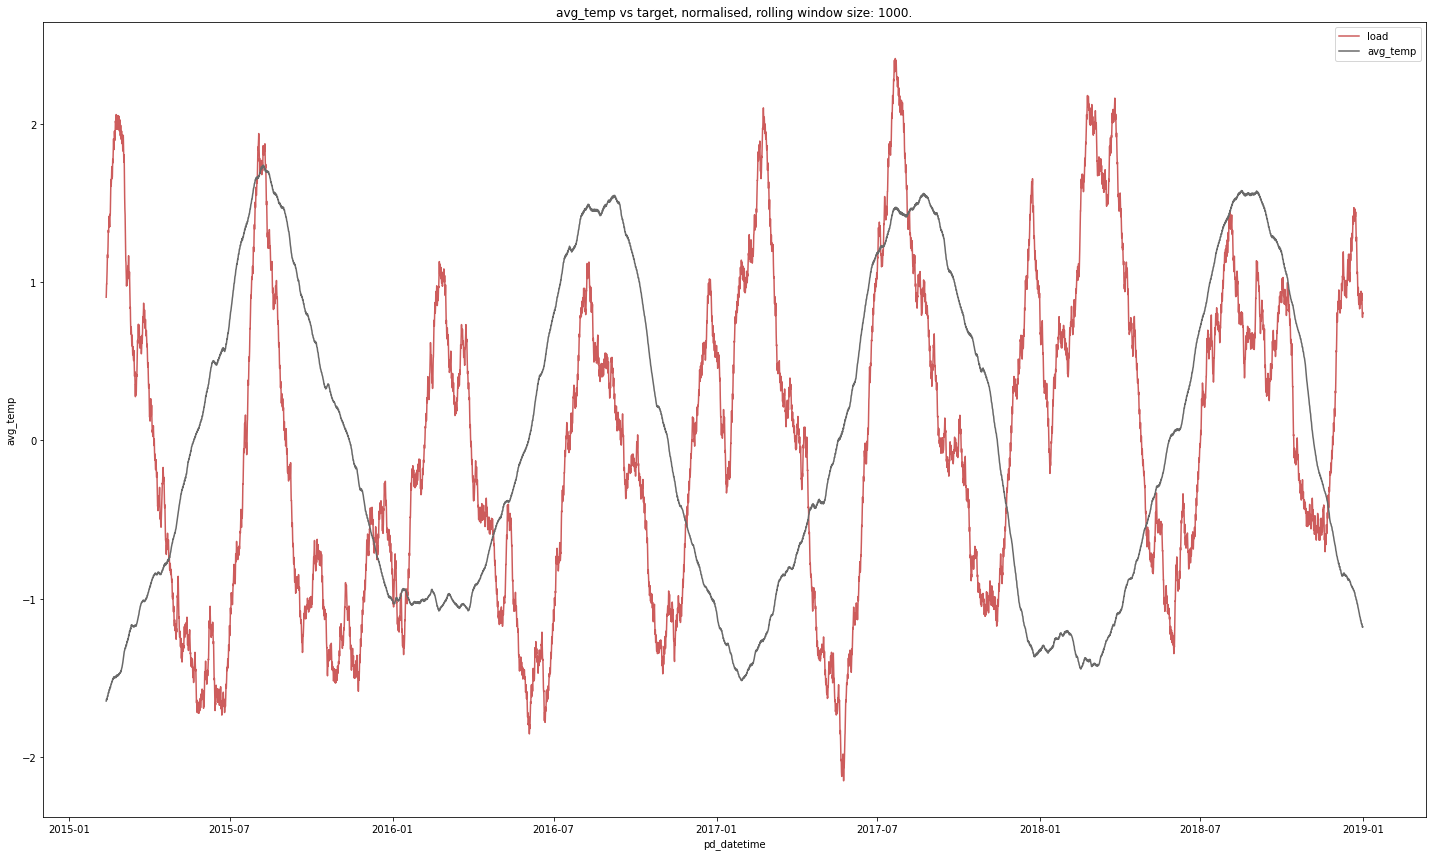

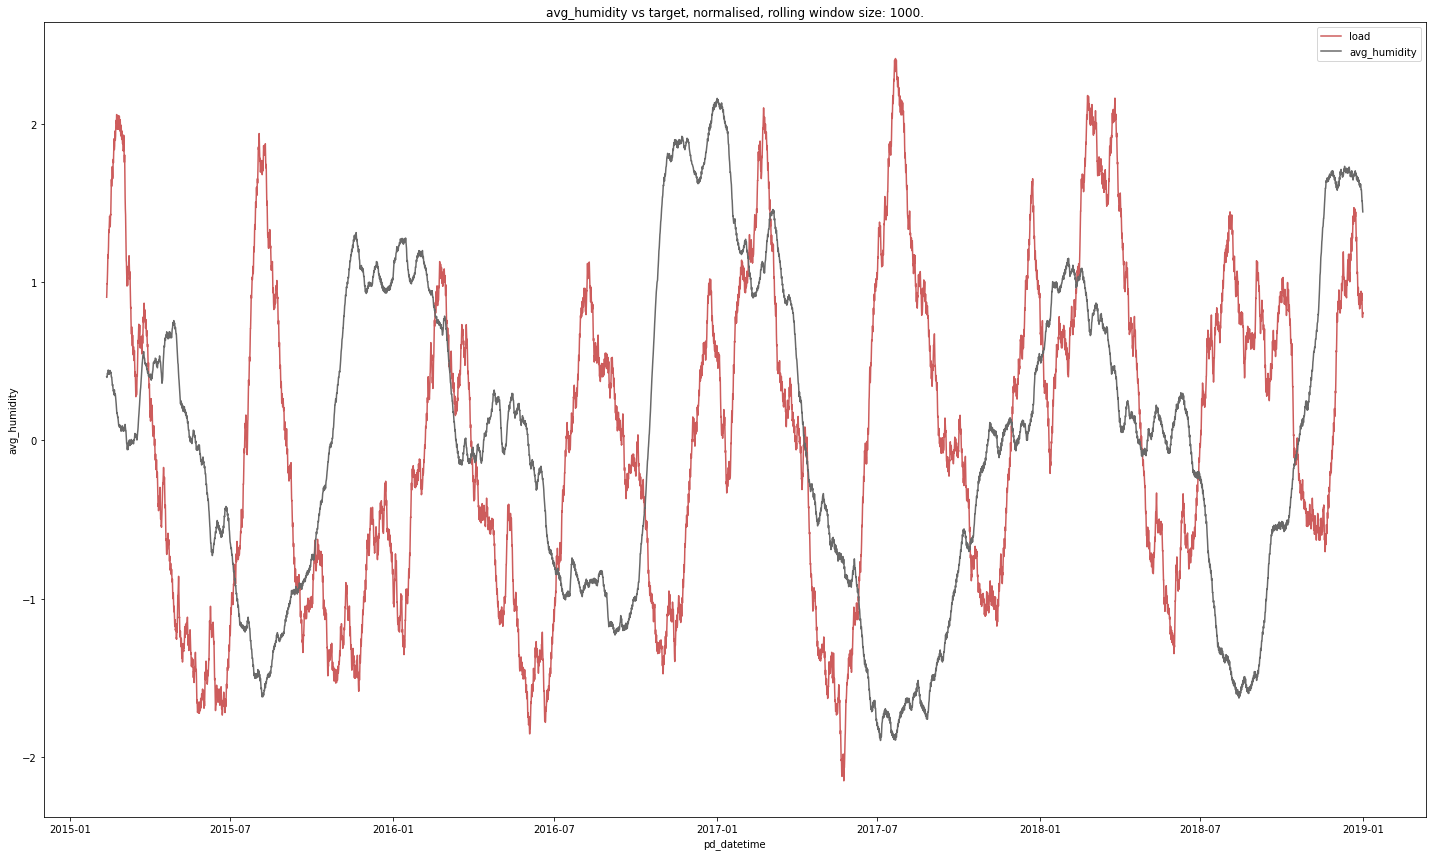

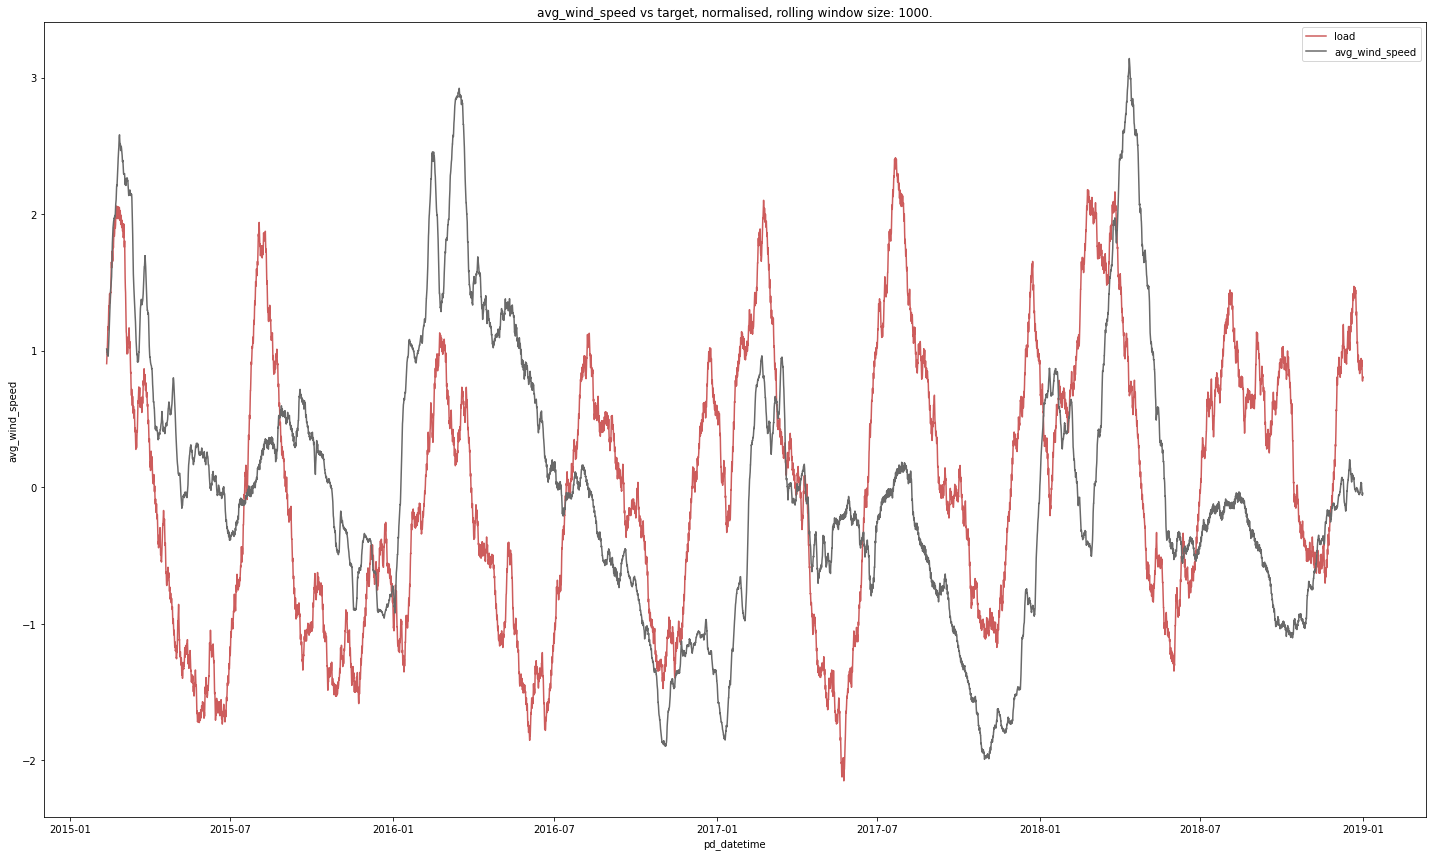

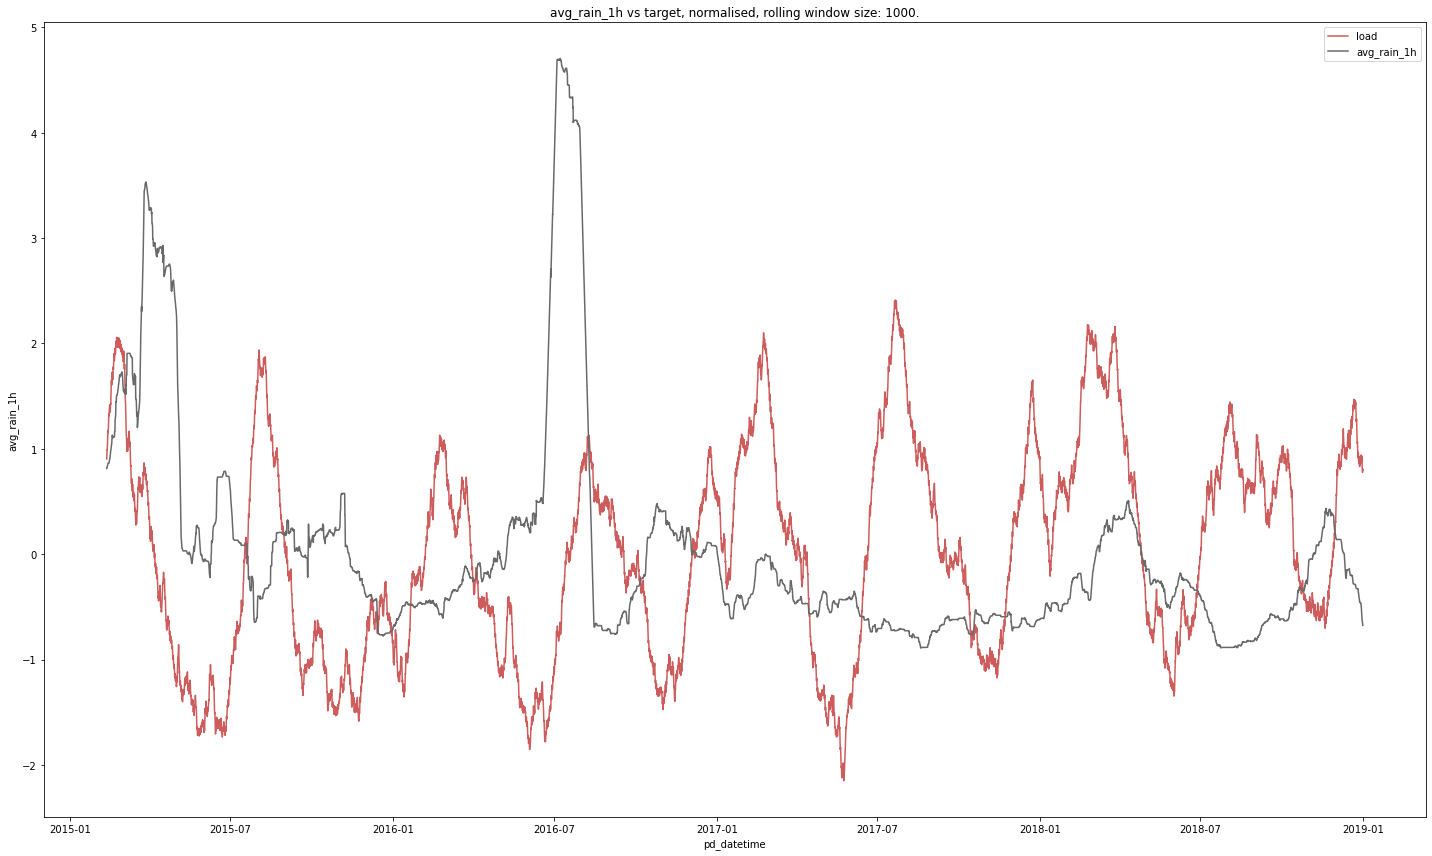

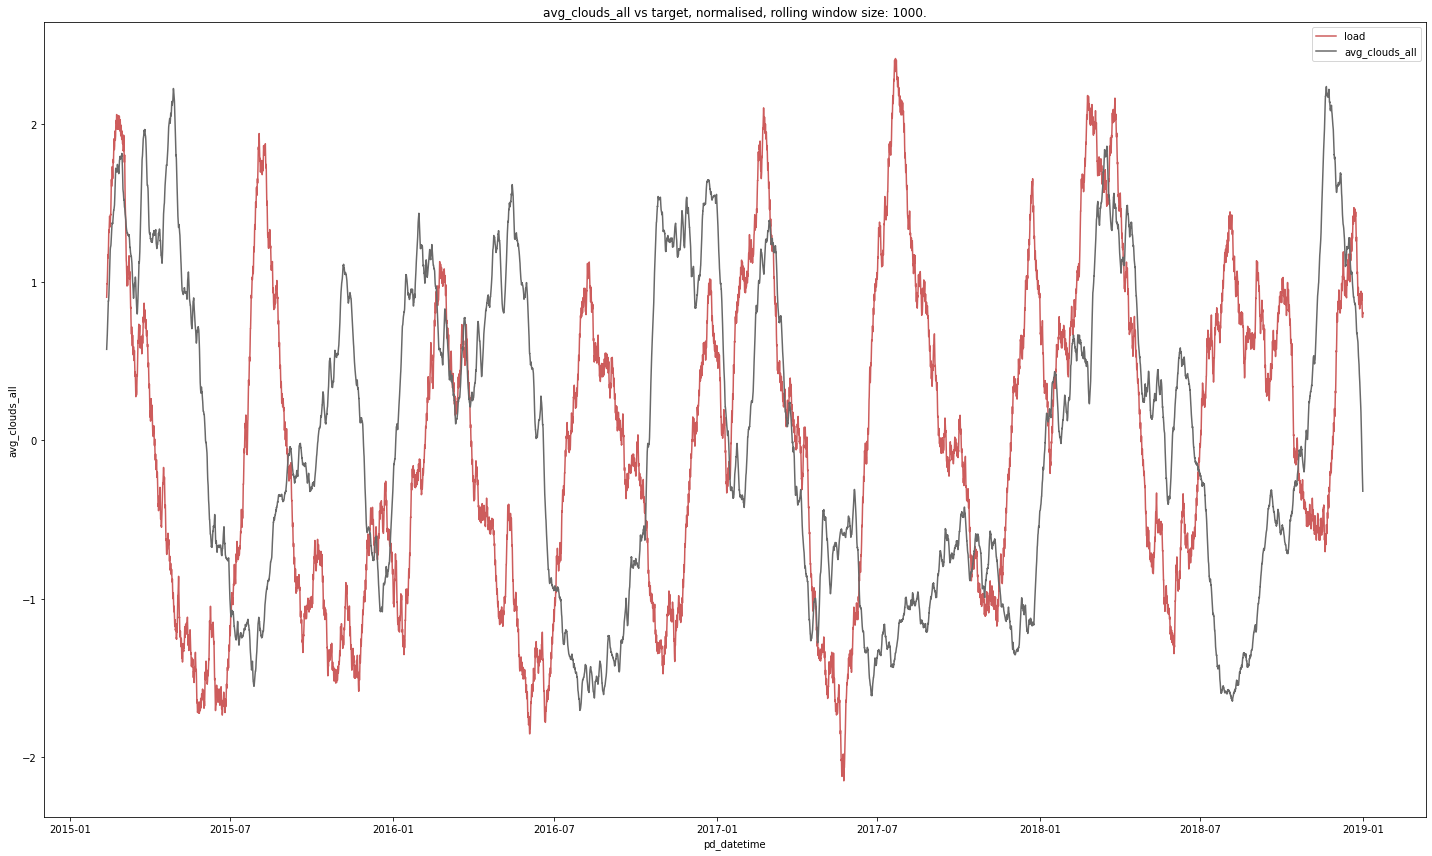

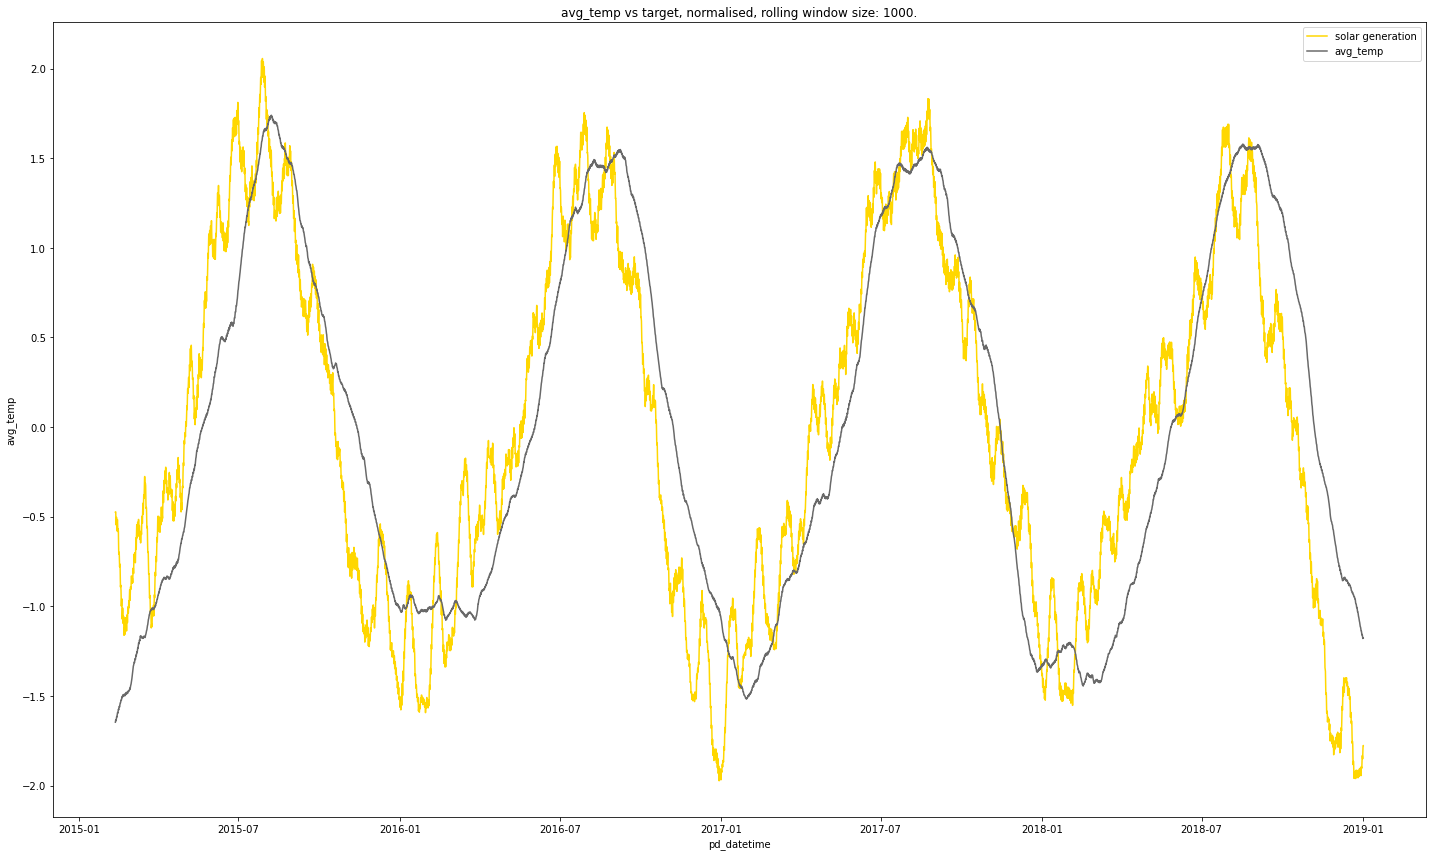

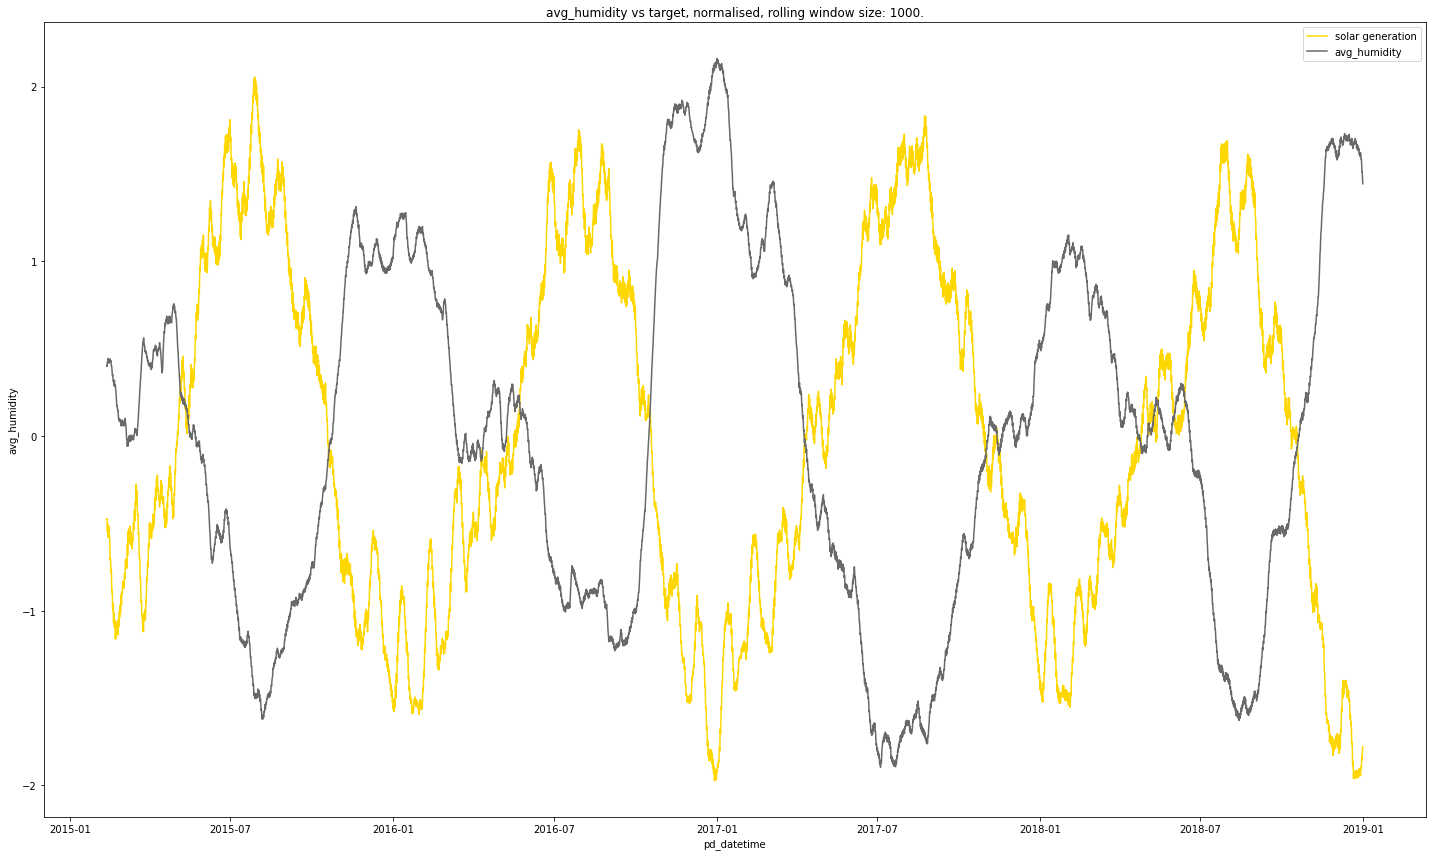

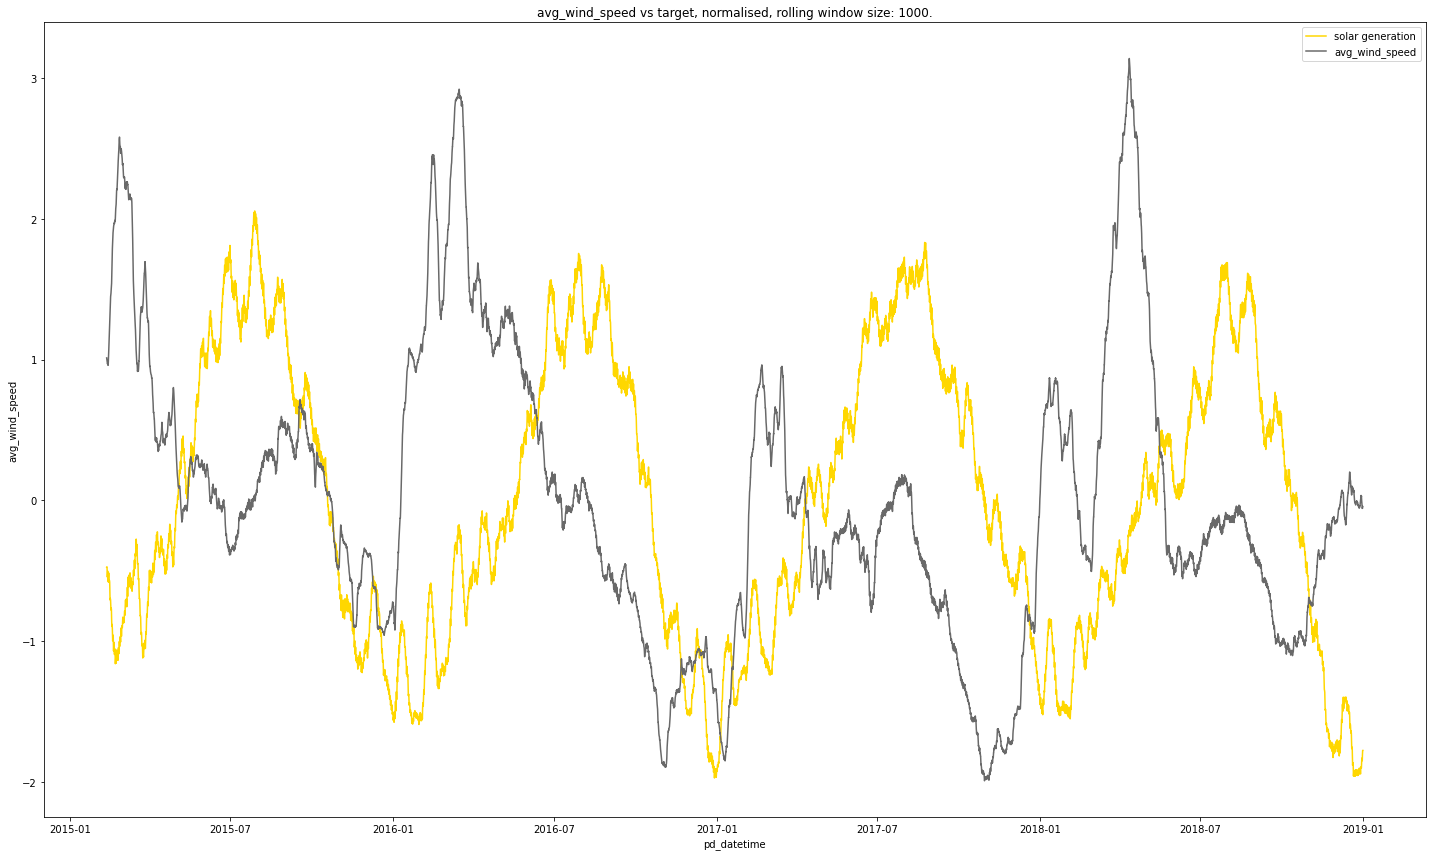

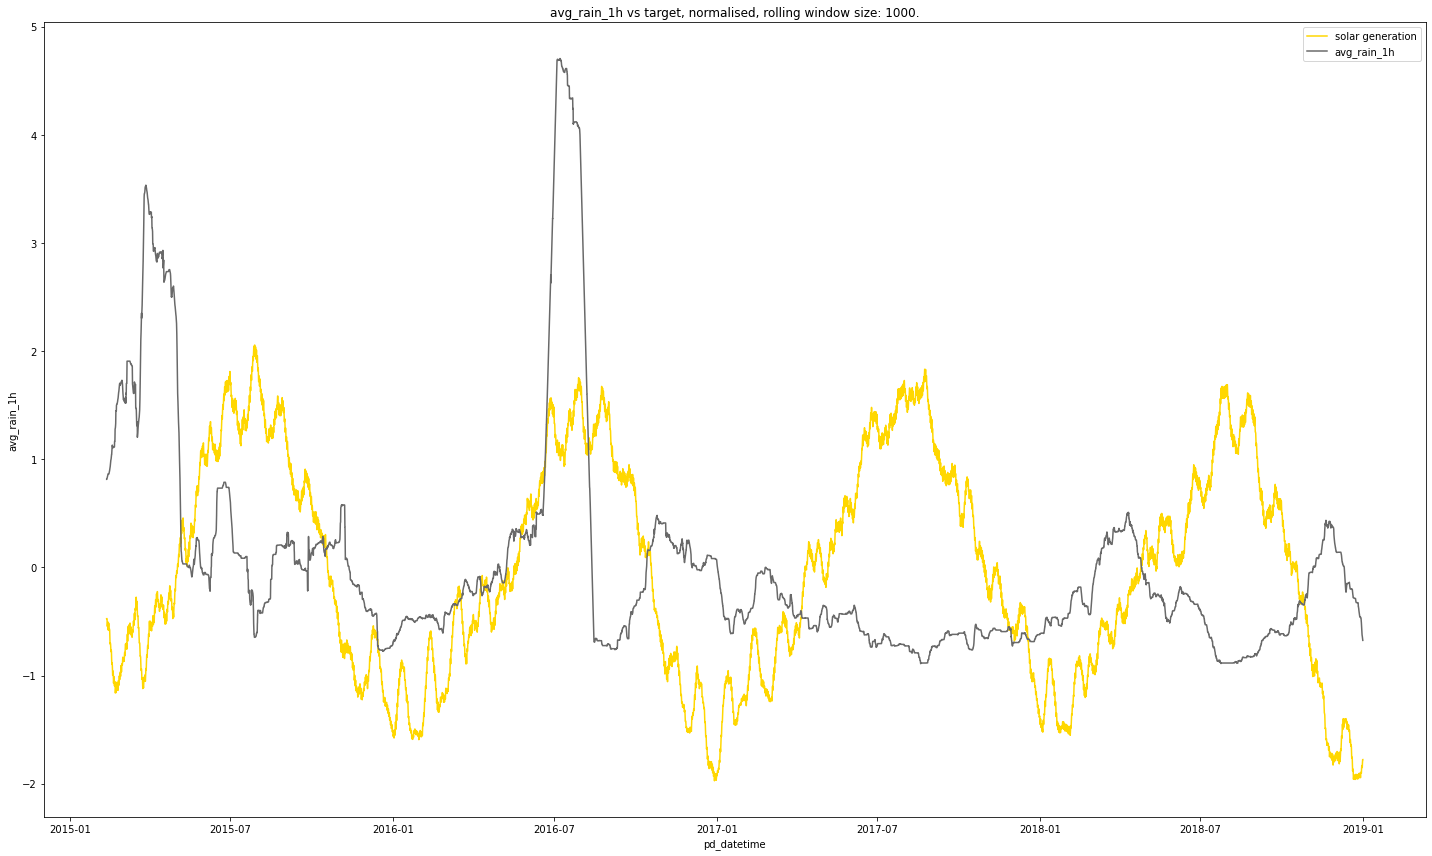

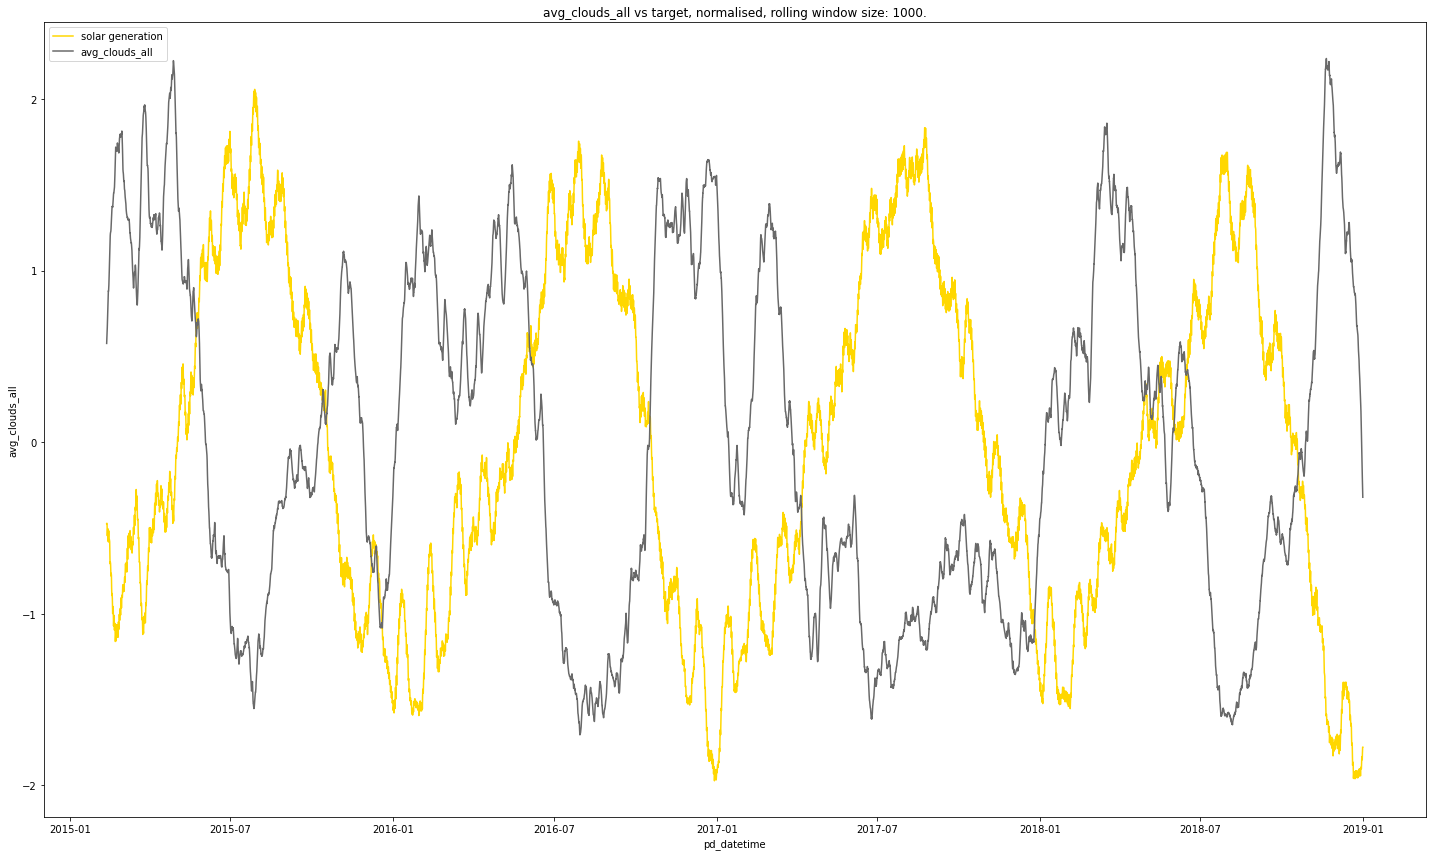

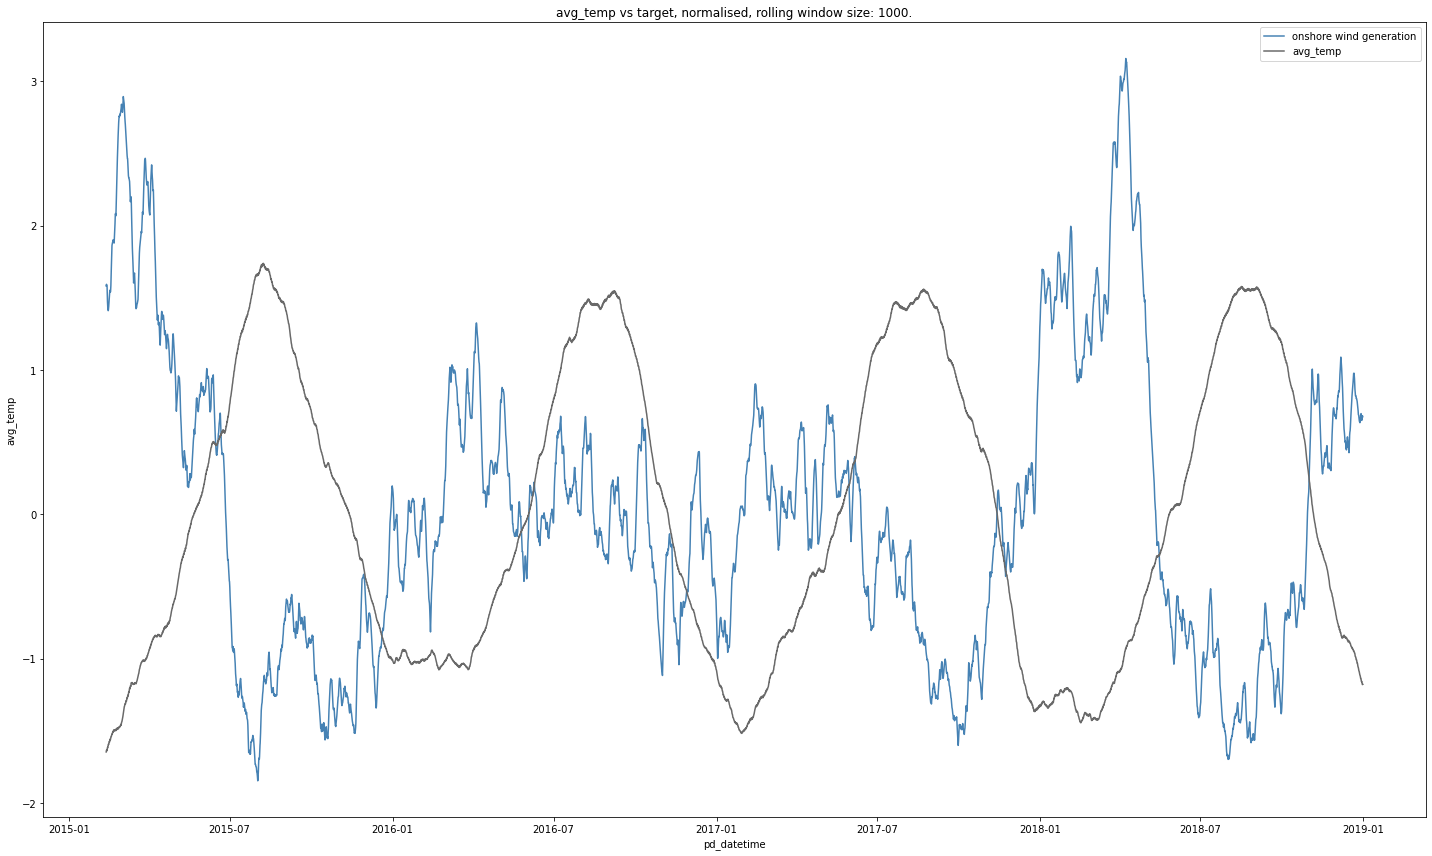

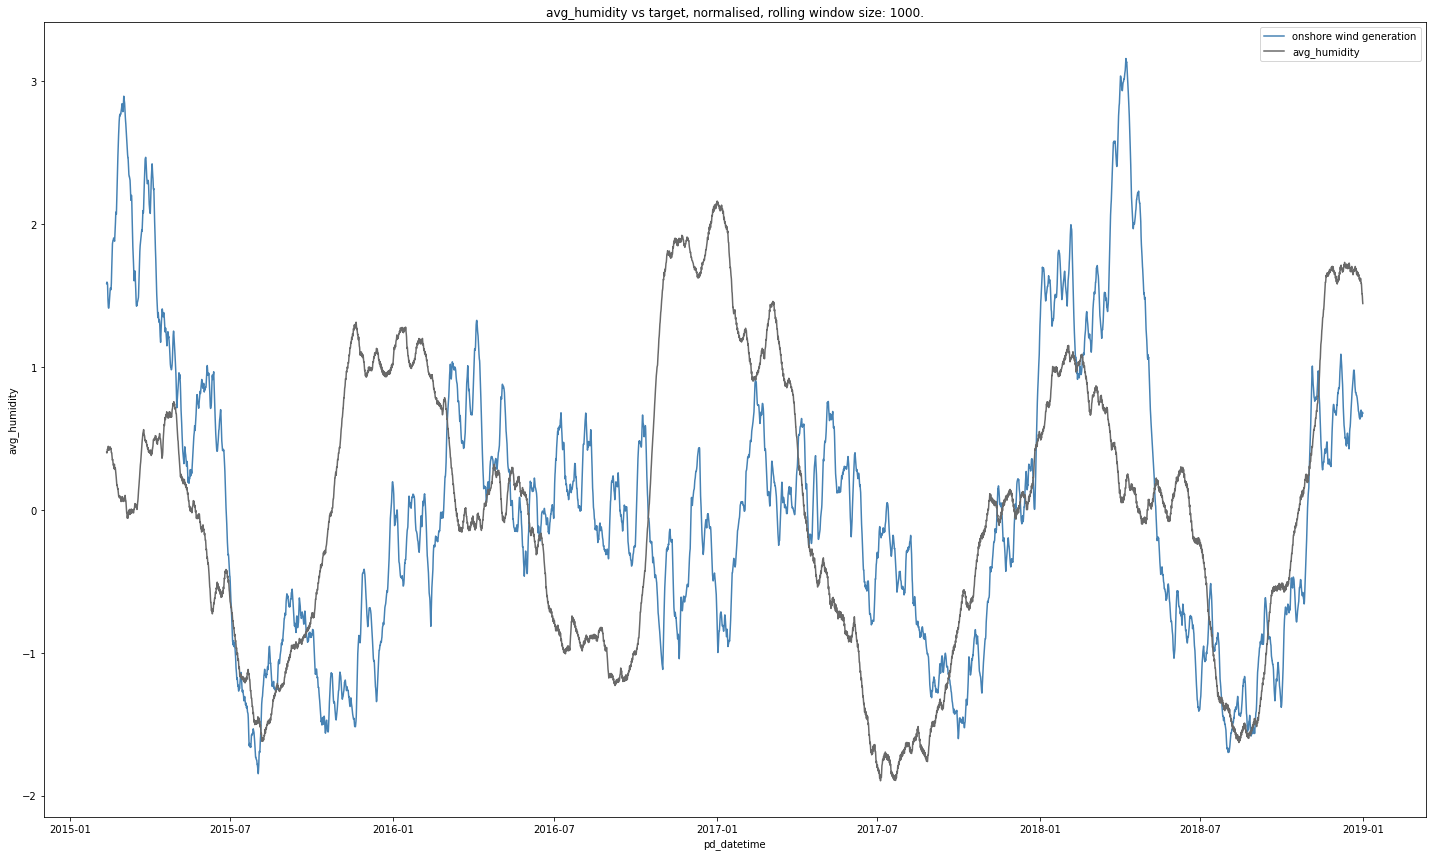

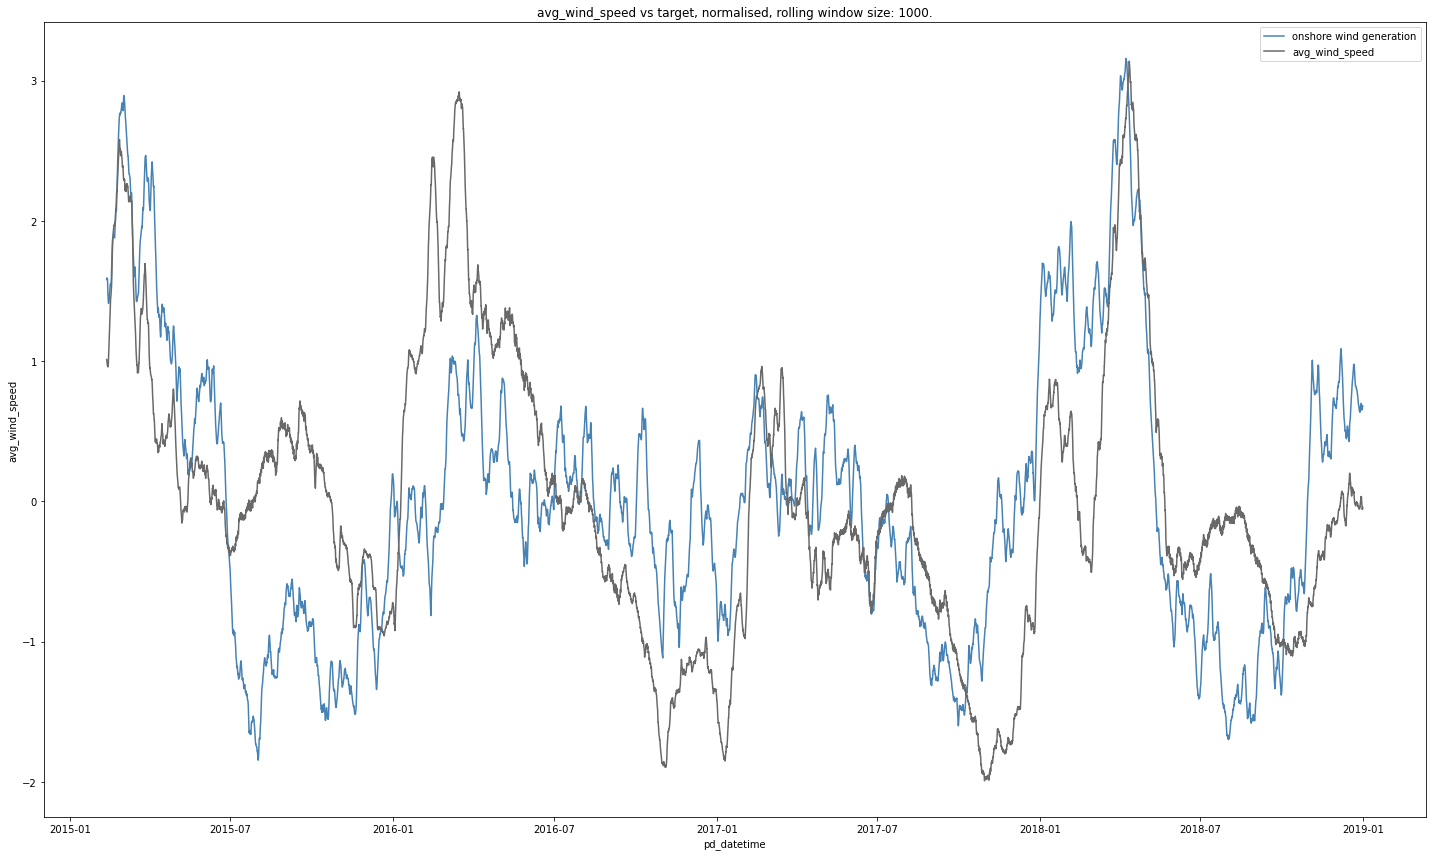

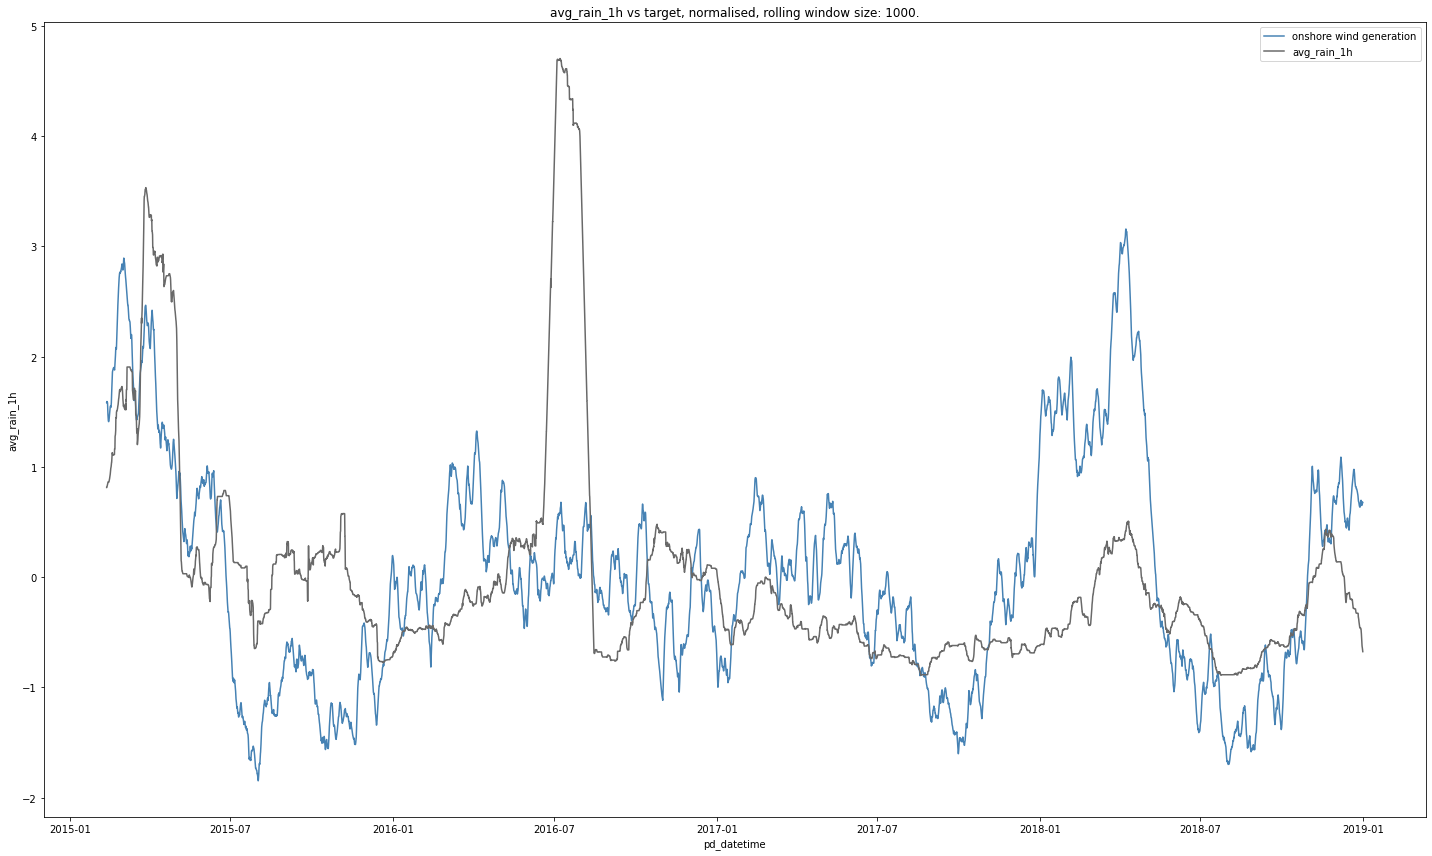

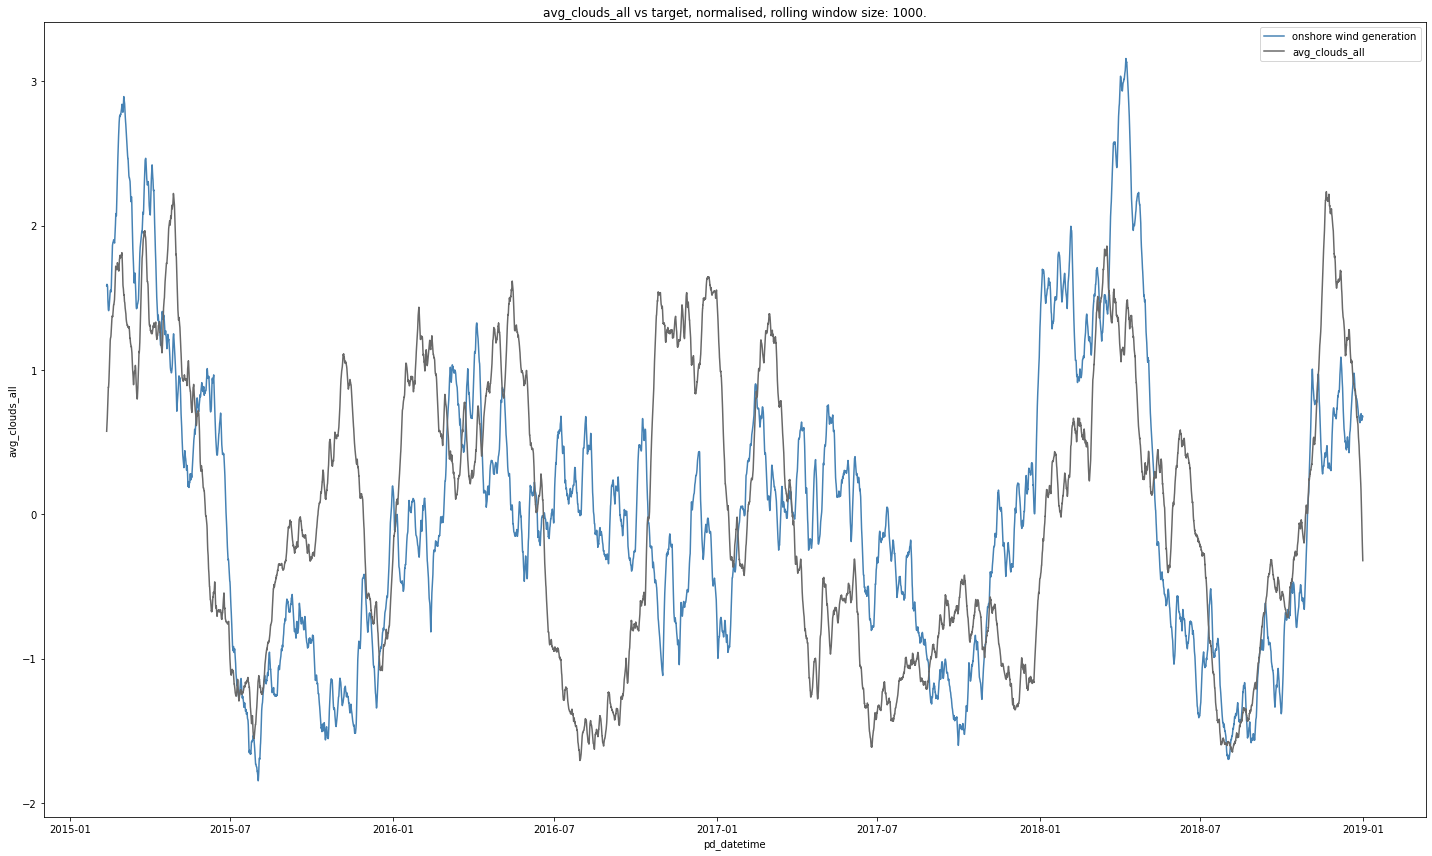

In [10]:
def plot_target_vs_exogenous_variable(target, column, rolling_window):
    plt.figure(figsize=(20, 12))
    
    rolling_avg_target = df[target].rolling(window=rolling_window).mean()
    rolling_avg_exo = df[column].rolling(window=rolling_window).mean()
    
    rolling_avg_target_normalised = (rolling_avg_target - rolling_avg_target.mean()) / rolling_avg_target.std()
    rolling_avg_exo_normalised = (rolling_avg_exo - rolling_avg_exo.mean()) / rolling_avg_exo.std()
    
    if target == "total load actual":
        sns.lineplot(data=df, x=df.index, y=rolling_avg_target_normalised, label=f"load", color="#CD5C5C")
    elif target == "generation solar":
        sns.lineplot(data=df, x=df.index, y=rolling_avg_target_normalised, label=f"solar generation", color="#FFD700")
    elif target == "generation wind onshore":
        sns.lineplot(data=df, x=df.index, y=rolling_avg_target_normalised, label=f"onshore wind generation", color="#4682B4")
    else: 
        raise ValueError("Target value not recognised. Make sure it's a string.")
    sns.lineplot(data=df, x=df.index, y=rolling_avg_exo_normalised, label=f"{column}", color="#696969")

    plt.title(f"{column} vs target, normalised, rolling window size: {rolling_window}.")
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

for target in target_columns:
    for column in exo_columns:
        plot_target_vs_exogenous_variable(target, column, rolling_window=1000)

<h3>General Statistics for Variables</h3>

In [11]:
df_for_stat_analysis = df.drop(columns=["time", "month", "year", "year_month"])

statistics = {
    "Mean": df_for_stat_analysis.mean(),
    "Standard Deviation": df_for_stat_analysis.std(),
    "Variance": df_for_stat_analysis.var(),
    "Min": df_for_stat_analysis.min(),
    "Max": df_for_stat_analysis.max(),
    "Kurtosis": df_for_stat_analysis.kurt(),
    "Skewness": df_for_stat_analysis.skew(),
    "25th Percentile": df_for_stat_analysis.quantile(0.25),
    "Median": df_for_stat_analysis.median(),
    "75th Percentile": df_for_stat_analysis.quantile(0.75)
}

statistics_df = pd.DataFrame(statistics) 

display_table(statistics_df, "Dataframe Statistics")


Dataframe Statistics
